# London bike Machine Learning project



- Projekt: Maschinelles Lernen mit Londoner Fahrradnutzungsdaten
- Ziel: Vorhersage zukünftiger Fahrradnutzungen
- Datenquellen: TfL Open Data, Wetterdaten von freemeteo.com, Feiertagsdaten von gov.uk
- Zeitraum der Daten: 04.01.2015 bis 03.01.2017
- Datengruppierung nach Startzeit, um die Anzahl neuer Fahrradnutzungen pro Stunde zu erfassen
- Berücksichtigung von Temperatur, Luftfeuchtigkeit, Windgeschwindigkeit, Wetterbedingungen, Feiertagen, Wochenenden und Jahreszeiten
- Lizenz von TfL Open Data erlaubt die Nutzung der Daten für kommerzielle und nicht-kommerzielle Zwecke unter bestimmten Bedingungen
- Ziel des Projekts: Verbesserung der Fahrradverteilung und -nutzung in London durch maschinelles Lernen und Datenanalyse.

In [206]:
#! pip install

In [207]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


## Section 1.  Daten kennenlernen

Der Datensatz wurde in ein Pandas-Datenframe geladen.

In [208]:
df_bike = pd.read_csv("london_merged.csv")

In [209]:
df_bike.head()

timestamp  cnt   t1   t2    hum  wind_speed  weather_code  \
0  2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
1  2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2  2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
3  2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
4  2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

   is_holiday  is_weekend  season  
0         0.0         1.0     3.0  
1         0.0         1.0     3.0  
2         0.0         1.0     3.0  
3         0.0         1.0     3.0  
4         0.0         1.0     3.0

Diese Daten enthalten historische Informationen über die Fahrradnutzung in London. Die Spalten in den Daten sind:

- **timestamp**: Der Zeitstempel für jede Stunde des Tages.
- **cnt**: Anzahl der geteilten Fahrräder.
- **t1**: Temperatur in Grad Celsius.
- **t2**: "Gefühlte" Temperatur in Grad Celsius.
- **hum**: Luftfeuchtigkeit.
- **wind_speed**: Windgeschwindigkeit.
- **weather_code**: Wettercode (1 für klares Wetter, 2 für teilweise bewölkt, 3 für etwas mehr bewölkt, 4 für bewölkt, 7 für Regen, 10 für Gewitter, 26 für Schnee).
- **is_holiday**: Ob es ein Feiertag ist oder nicht (1 = ja, 0 = nein).
- **is_weekend**: Ob es ein Wochenende ist oder nicht (1 = ja, 0 = nein).
- **season**: Jahreszeit (0 = Frühling, 1 = Sommer, 2 = Herbst, 3 = Winter).

In [210]:
df_bike.columns

Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season'],
      dtype='object')

In [211]:
df_bike.shape

(17414, 10)

In [212]:
print(
    "Die Gesamtzahl der Datensätze im Datensatz beträgt: "
    + str(df_bike.timestamp.count())
    + ", from: "
    + str(df_bike.timestamp.min())
    + " to: "
    + str(df_bike.timestamp.max())
)

Die Gesamtzahl der Datensätze im Datensatz beträgt: 17414, from: 2015-01-04 00:00:00 to: 2017-01-03 23:00:00


In [213]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


### 1.2 Data Cleaning

In [214]:
df_bike.rename(
    columns={"cnt": "count", "t1": "temp", "t2": "temp_feels_like", "hum": "humidity"},
    inplace=True,
)

In [215]:
df_bike["timestamp"] = pd.to_datetime(df_bike["timestamp"])

In [216]:
df_bike["year"] = df_bike["timestamp"].dt.year

In [217]:
df_bike["month"] = df_bike["timestamp"].dt.month_name()

In [218]:
df_bike["time"] = pd.to_datetime(df_bike["timestamp"]).dt.time

In [219]:
df_bike["day_of_week"] = df_bike["timestamp"].dt.day_name()

In [220]:
# تحويل رموز الفصول إلى أسماء
season_dict = {0.0: "Spring", 1.0: "Summer", 2.0: "Autumn", 3.0: "Winter"}
df_bike["season_name"] = df_bike["season"].map(season_dict)

In [221]:
df_bike["day"] = df_bike["timestamp"].dt.date

In [222]:
df_bike.describe()

timestamp         count          temp  \
count                          17414  17414.000000  17414.000000   
mean   2016-01-03 22:31:00.571953664   1143.101642     12.468091   
min              2015-01-04 00:00:00      0.000000     -1.500000   
25%              2015-07-04 20:15:00    257.000000      8.000000   
50%              2016-01-03 15:30:00    844.000000     12.500000   
75%              2016-07-04 15:45:00   1671.750000     16.000000   
max              2017-01-03 23:00:00   7860.000000     34.000000   
std                              NaN   1085.108068      5.571818   

       temp_feels_like      humidity    wind_speed  weather_code  \
count     17414.000000  17414.000000  17414.000000  17414.000000   
mean         11.520836     72.324954     15.913063      2.722752   
min          -6.000000     20.500000      0.000000      1.000000   
25%           6.000000     63.000000     10.000000      1.000000   
50%          12.500000     74.500000     15.000000      2.000000   
75%          16.000000     83.000000     20.500000      3.000000   
max          34.000000    100.000000     56.500000     26.000000   
std           6.615145     14.313186      7.894570      2.341163   

         is_holiday    is_weekend        season          year  
count  17414.000000  17414.000000  17414.000000  17414.000000  
mean       0.022051      0.285403      1.492075   2015.507810  
min        0.000000      0.000000      0.000000   2015.000000  
25%        0.000000      0.000000      0.000000   2015.000000  
50%        0.000000      0.000000      1.000000   2016.000000  
75%        0.000000      1.000000      2.000000   2016.000000  
max        1.000000      1.000000      3.000000   2017.000000  
std        0.146854      0.451619      1.118911      0.508157

- **count**: Die Standardabweichung der Anzahl der geteilten Fahrräder beträgt 1085. Dies bedeutet, dass es große Schwankungen in der Anzahl der geteilten Fahrräder pro Stunde gibt. Dies könnte die sich ändernde Nachfrage nach Fahrrad-Sharing im Laufe des Tages widerspiegeln.
- **temp** und **temp_feels_like**: Die Standardabweichungen der Temperaturen (tatsächlich und "gefühlte") betragen etwa 5,5 bzw. 6,6 Grad Celsius. Dies spiegelt die natürlichen Temperaturschwankungen im Laufe des Tages und der Nacht wider.
- **humidity**: Die Standardabweichung der Luftfeuchtigkeit beträgt etwa 14,3, was auf Schwankungen in den Feuchtigkeitswerten hinweist.
- **wind_speed**: Die Standardabweichung der Windgeschwindigkeit beträgt etwa 7,9, was auf Schwankungen in den Windgeschwindigkeiten hinweist.
- **weather_code**: Die Standardabweichung des Wetters beträgt etwa 2,3, was auf Schwankungen in den Wetterbedingungen hinweist.
- **is_holiday** und **is_weekend**: Der Durchschnittswert dieser Spalten ist kleiner als 0,5, was darauf hindeut


من الجدول المستخرج من df_bike.describe()، يمكننا استخلاص النقاط التالية:

- **cnt**: الانحراف المعياري لعدد الدراجات المشتركة هو 1085. هذا يعني أن هناك تقلبات كبيرة في عدد الدراجات المشتركة في كل ساعة. هذا قد يعكس الطلب المتغير على مشاركة الدراجات خلال اليوم.
- **t1** و **t2**: الانحراف المعياري لدرجات الحرارة (الفعلية و"الملموسة") هو حوالي 5.5 و6.6 على التوالي. هذا يعكس التقلبات الطبيعية في درجات الحرارة خلال اليوم والليل.
- **hum**: الانحراف المعياري لنسبة الرطوبة هو حوالي 14.3، مما يشير إلى تقلبات في مستويات الرطوبة.
- **wind_speed**: الانحراف المعياري لسرعة الرياح هو حوالي 7.9، مما يشير إلى تقلبات في سرعة الرياح.
- **weather_code**: الانحراف المعياري لرمز الطقس هو حوالي 2.3، مما يشير إلى تقلبات في ظروف الطقس.
- **is_holiday** و **is_weekend**: متوسط قيم هذه الأعمدة أقل من 0.5، مما يشير إلى أن معظم الأيام في البيانات ليست أيام عطلات أو نهاية أسبوع.
- **season**: متوسط قيم هذا العمود هو حوالي 1.5، مما يشير إلى أن معظم الأيام في البيانات تقع في فصول متأخرة من السنة (الصيف والخريف).



In [223]:
df_bike["timestamp"].value_counts()

timestamp
2015-01-04 00:00:00    1
2016-05-04 12:00:00    1
2016-05-04 18:00:00    1
2016-05-04 17:00:00    1
2016-05-04 16:00:00    1
                      ..
2015-09-03 17:00:00    1
2015-09-03 18:00:00    1
2015-09-03 19:00:00    1
2015-09-03 20:00:00    1
2017-01-03 23:00:00    1
Name: count, Length: 17414, dtype: int64

Es gibt 17414 verschiedene timestamps, die jeweils nur einmal vorkommen.
17414/24/2 = 362.791666666666,
das heißt es liegen durchschnittlich zu 362.8 Tagen pro Jahr Daten vor. Die Daten sind also fast vollständig.

In [224]:
df_bike["is_weekend"].value_counts()

is_weekend
0.0    12444
1.0     4970
Name: count, dtype: int64

In [225]:
df_bike["season"].value_counts()

season
0.0    4394
1.0    4387
3.0    4330
2.0    4303
Name: count, dtype: int64

Etwa 2/7 der Zeilen sind Wochenenden.
Alle Jahreszeiten treten etwa gleich häufig auf.
Das weist auf die Korrektheit der Daten hin. Die geringe Abweichung lässt sich durch die fehlenden Daten zu 2-3 Tagen pro Jahr erklären.

In [226]:
df_bike["weather_code"].value_counts()

weather_code
1.0     6150
2.0     4034
3.0     3551
7.0     2141
4.0     1464
26.0      60
10.0      14
Name: count, dtype: int64

Sonniges, bewölktes und regnerisches Wetter treten meistens auf. Gewitter und Schnee nur ziemlich selten.

In [227]:
df_bike["is_holiday"].value_counts()

is_holiday
0.0    17030
1.0      384
Name: count, dtype: int64

In [228]:
print("Feiertage pro Jahr: ~", 384 / 17414 * 365.25)

Feiertage pro Jahr: ~ 8.05420925691972


## Section 2. Data visualization

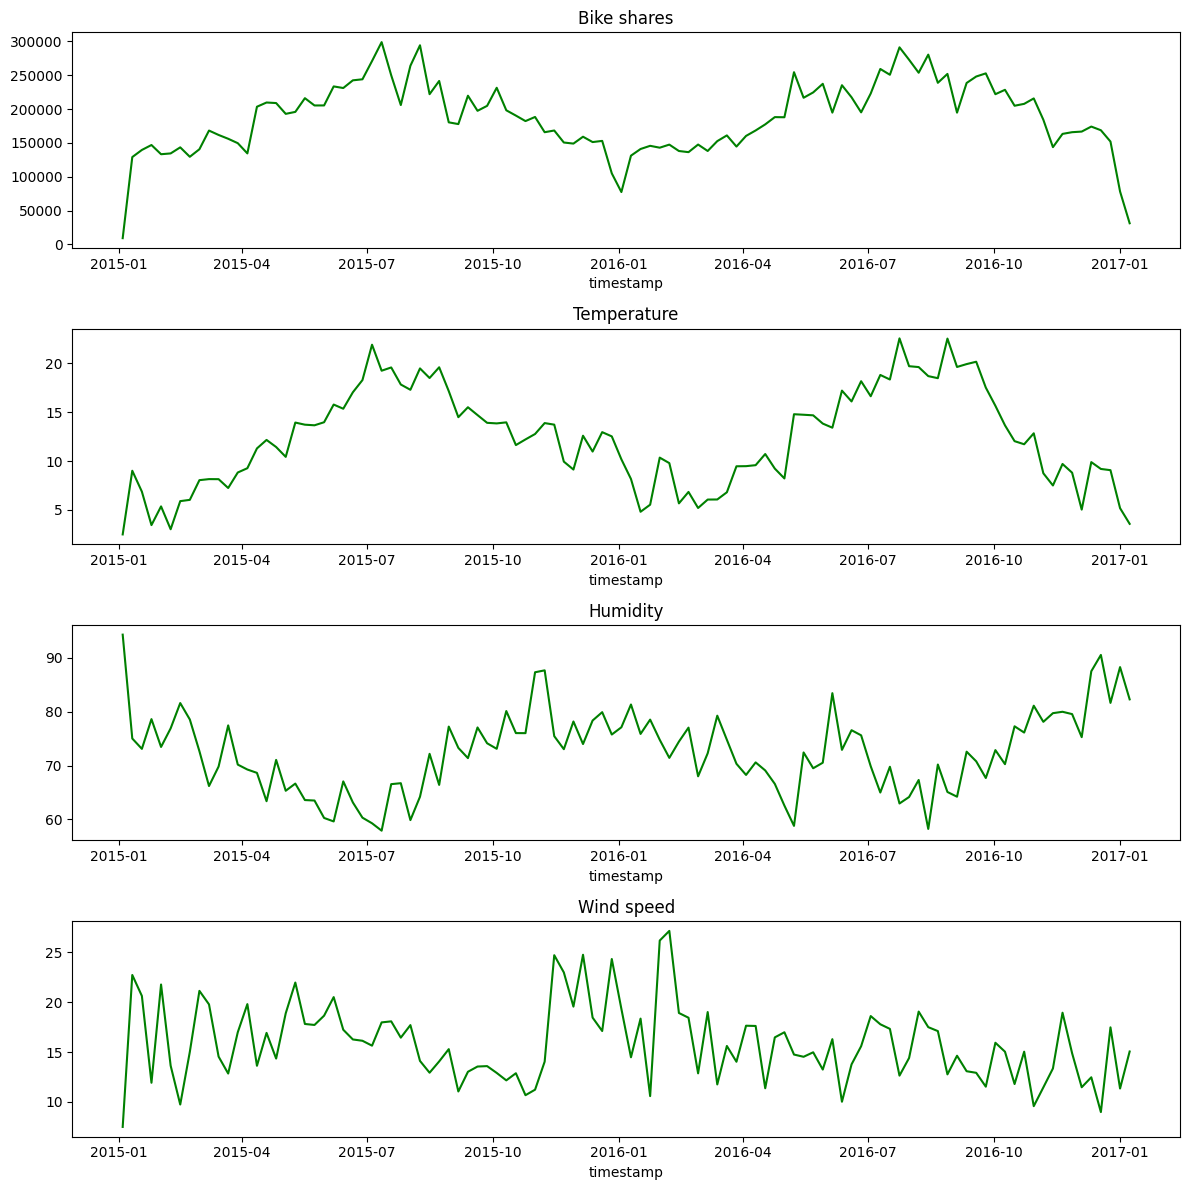

In [229]:
df_bike.index = pd.to_datetime(df_bike["timestamp"])

agg_freq = "1W"  # agg_freq = "1W": هذا يحدد التردد الذي سيتم استخدامه لتجميع البيانات. في هذه الحالة، “1W” يعني أن البيانات ستتم تجميعها بناءً على الأسبوع.

counts = (
    df_bike["count"].groupby(pd.Grouper(freq=agg_freq)).sum()
)  # عند استخدام pd.Grouper, يجب أن يكون الفهرس من نوع DatetimeIndex لأن pd.Grouper يقوم بتجميع البيانات بناءً على التواريخ
temps = (
    df_bike["temp"].groupby(pd.Grouper(freq=agg_freq)).mean()
)  # هذا يقوم بتجميع درجات الحرارة (“t1”) بناءً على التردد الذي حددناه ويحسب المتوسط لكل أسبوع.
hums = df_bike["humidity"].groupby(pd.Grouper(freq=agg_freq)).mean()
winds = df_bike["wind_speed"].groupby(pd.Grouper(freq=agg_freq)).mean()

fig, axes = plt.subplots(4, 1)
fig.set_figheight(12)
fig.set_figwidth(12)
axes[0].set_title("Bike shares")
sns.lineplot(x=counts.index, y=counts.values, ax=axes[0], color="green")
axes[1].set_title("Temperature")
sns.lineplot(x=temps.index, y=temps.values, ax=axes[1], color="green")
axes[2].set_title("Humidity")
sns.lineplot(x=hums.index, y=hums.values, ax=axes[2], color="green")
axes[3].set_title("Wind speed")
sns.lineplot(x=winds.index, y=winds.values, ax=axes[3], color="green")
plt.tight_layout()

Aus den Diagrammen können wir folgende Punkte ableiten:

- **Fahrradfreigabe**: Es scheint ein saisonales Muster für die Fahrradfreigabe zu geben, mit einer Zunahme der Nachfrage in den wärmeren Monaten und einem Rückgang in den kälteren Monaten. Dies spiegelt die Auswirkungen des Wetters auf die Fahrradfreigabe wider.
- **Temperatur**: Die Temperaturen folgen einem erwarteten saisonalen Muster, mit steigenden Temperaturen im Sommer und fallenden Temperaturen im Winter.
- **Feuchtigkeit**: Es scheint einen allgemeinen Trend zu einer Zunahme der Feuchtigkeit im Laufe des Jahres zu geben, mit einigen saisonalen Schwankungen.
- **Windgeschwindigkeit**: Es gibt kein klares Muster für die Windgeschwindigkeit, aber es scheint einige saisonale Schwankungen zu geben.



من الرسوم البيانية، يمكننا استخلاص النقاط التالية:

- **مشاركة الدراجات**: يبدو أن هناك نمطًا موسميًا لمشاركة الدراجات، مع زيادة في الطلب خلال الأشهر الأكثر دفئًا وانخفاض خلال الأشهر الأكثر برودة. هذا يعكس تأثير الطقس على مشاركة الدراجات.
- **الحرارة**: تتبع درجات الحرارة نمطًا موسميًا متوقعًا، مع ارتفاع درجات الحرارة في فصل الصيف وانخفاضها في فصل الشتاء.
- **الرطوبة**: يبدو أن هناك اتجاهًا عامًا نحو زيادة الرطوبة على مدار العام، مع بعض التقلبات الموسمية.
- **سرعة الرياح**: ليست هناك أي نمط واضح لسرعة الرياح، لكن يبدو أن هناك بعض التقلبات الموسمية.




### Korrelationen in Wetterdaten: 
Um ein besseres Verständnis der statistischen Eigenschaften der Wetterdaten zu erhalten, wird ein paarweiser Multi-Streuungsplot erstellt. Hier kann festgestellt werden, dass es eine starke Korrelation zwischen der realen Temperatur (temp_real) und der gefühlten Temperatur (temp_feels) gibt, während die anderen Variablen höchstens schwach korreliert sind. Daher könnten alle interessant sein, um weiter untersucht zu werden.


"الارتباطات في بيانات الطقس
للحصول على فهم أفضل للخصائص الإحصائية لبيانات الطقس، يتم إنشاء رسم بياني متعدد للنقاط الزوجية. هنا يمكن ملاحظة أنه بينما هناك ارتباط قوي بين درجة الحرارة الحقيقية (temp_real) ودرجة الحرارة المحسوسة (temp_feels)، فإن المتغيرات الأخرى مرتبطة ضعيفة على الأكثر. وبالتالي، قد يكون من المثير للاهتمام التحقيق فيها جميعًا."

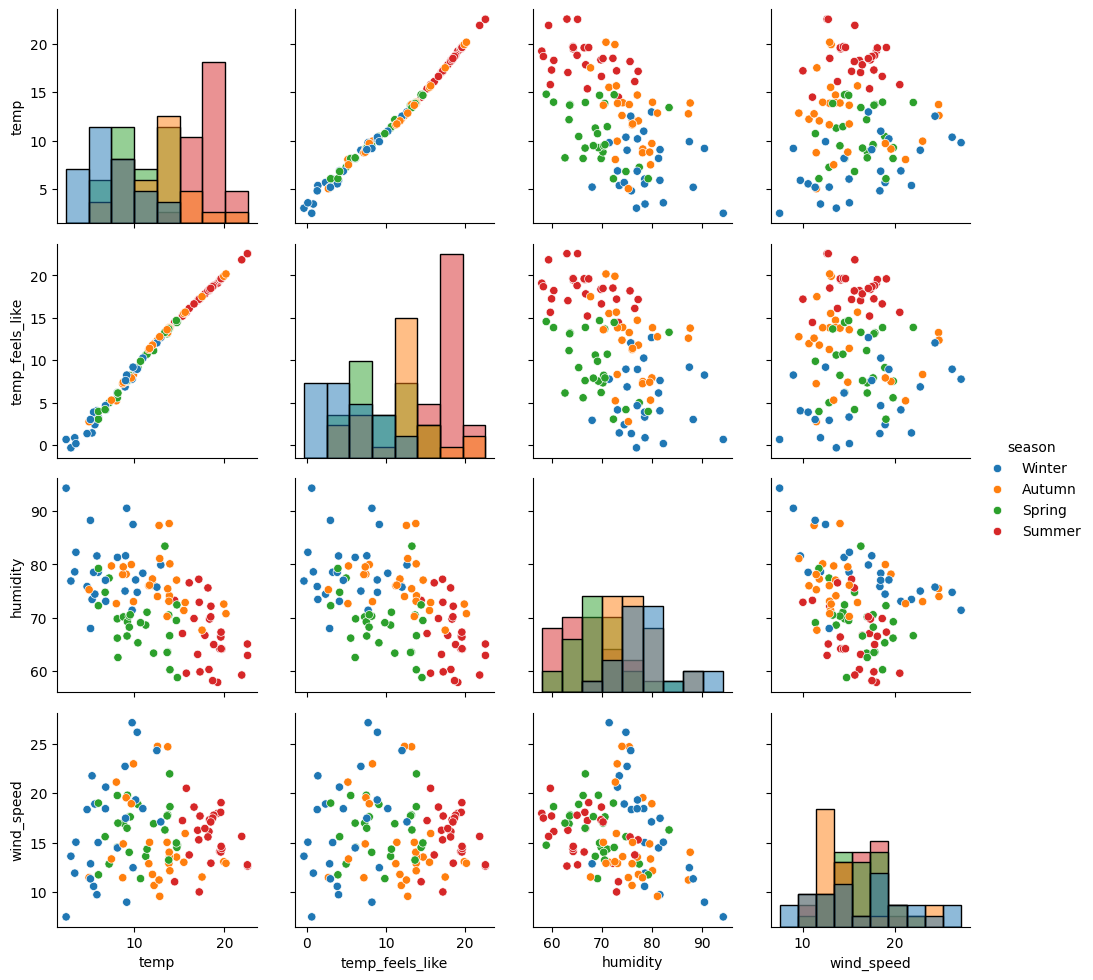

In [230]:
mean_agg = (
    df_bike[["temp", "temp_feels_like", "humidity", "wind_speed", "season"]]
    .groupby(pd.Grouper(freq=agg_freq))
    .mean()
)

season_key = ["Spring", "Summer", "Autumn", "Winter"]
seasons = (
    mean_agg["season"]
    .apply(lambda x: int(np.floor(x)))
    .apply(
        lambda x: season_key[x]
    )  # هذا يقوم بتحويل قيم الموسم في mean_agg من أرقام إلى أسماء الفصول باستخدام season_key. يتم تخزين النتائج في seasons.
)
mean_agg["season"] = seasons

g = sns.PairGrid(mean_agg, hue="season")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

### Korrelationen zwischen der Nutzung von Fahrrädern und Wetterdaten:
Mögliche Korrelationen zwischen Wetterdaten und aggregierter Fahrradnutzung (unter Verwendung derselben Zeitintervalle wie in den vorherigen Abschnitten) werden untersucht.

In [231]:
weather_counts = mean_agg[["temp", "humidity", "wind_speed", "season"]].join(counts)
weather_counts

temp   humidity  wind_speed  season   count
timestamp                                                  
2015-01-04  2.479167  94.270833    7.500000  Winter    9234
2015-01-11  9.002994  75.008982   22.715569  Winter  129038
2015-01-18  6.863095  73.092262   20.619048  Winter  139559
2015-01-25  3.434524  78.604167   11.922619  Winter  146866
2015-02-01  5.351190  73.446429   21.761905  Winter  133247
...              ...        ...         ...     ...     ...
2016-12-11  9.886905  87.479167   12.470238  Winter  174112
2016-12-18  9.187500  90.505952    8.985119  Winter  168680
2016-12-25  9.062500  81.613095   17.470238  Winter  151948
2017-01-01  5.169643  88.250000   11.345238  Winter   78188
2017-01-08  3.562500  82.270833   15.052083  Winter   31259

[106 rows x 5 columns]

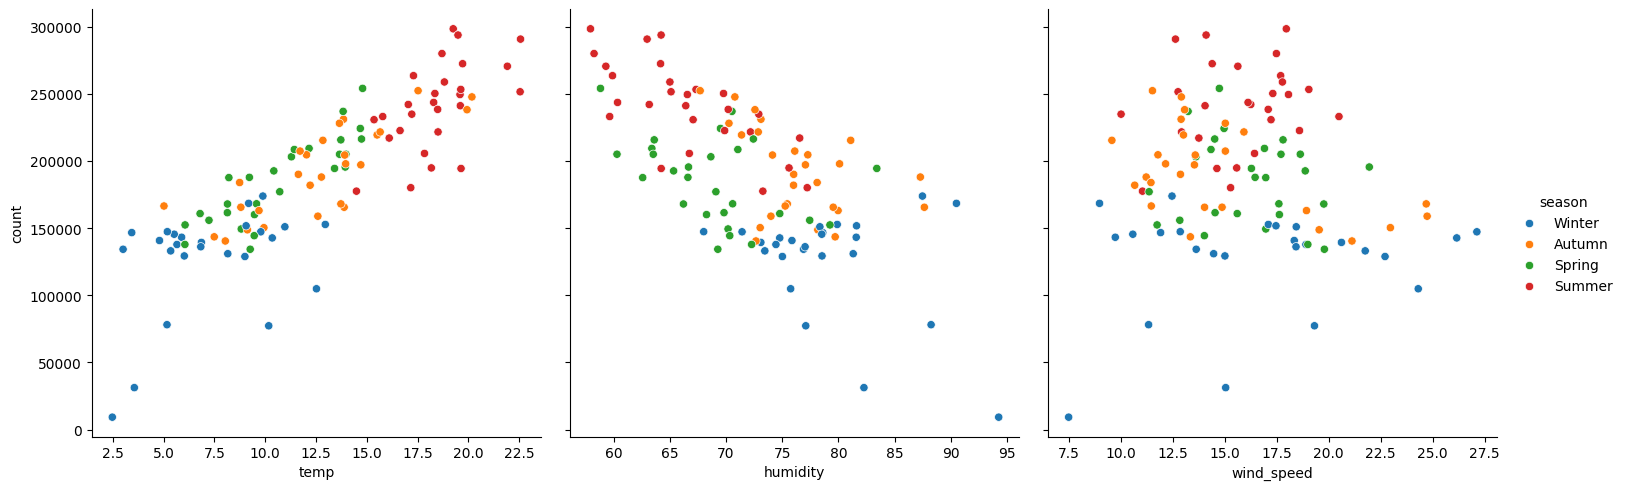

In [232]:
g = sns.PairGrid(
    weather_counts,
    x_vars=[
        "temp",
        "humidity",
        "wind_speed",
    ],
    y_vars="count",
    hue="season",
    height=5,
    # palette="pastel",
)
g.map(sns.scatterplot)
g.add_legend()

Aus dem Diagramm können wir folgende Punkte ableiten:

- **Temperatur (t1)**: Es scheint eine positive Korrelation zwischen der Temperatur und der Anzahl der geteilten Fahrräder zu geben. Das bedeutet, dass normalerweise, wenn die Temperatur steigt, die Anzahl der geteilten Fahrräder ebenfalls steigt.
- **Feuchtigkeit (hum)**: Es scheint eine negative Korrelation zwischen der Feuchtigkeit und der Anzahl der geteilten Fahrräder zu geben. Das bedeutet, dass normalerweise, wenn die Feuchtigkeit steigt, die Anzahl der geteilten Fahrräder abnimmt.
- **Windgeschwindigkeit (wind_speed)**: Es scheint keine klare Korrelation zwischen der Windgeschwindigkeit und der Anzahl der geteilten Fahrräder zu geben. Dies könnte darauf hindeuten, dass die Windgeschwindigkeit keinen großen Einfluss auf das Fahrrad-Sharing hat.
- **Jahreszeit (season)**: Der Wechsel der Punktfarben zeigt, dass es saisonale Unterschiede in allen Variablen gibt. Zum Beispiel können Sie in dem Diagramm von t1 gegen cnt verschiedene farbige Punkte sehen, was darauf hindeutet, dass die Anzahl der geteilten Fahrräder je nach Jahreszeit variiert.



<div dir="rtl">



من الرسم البياني، يمكننا استخلاص النقاط التالية:

- **الحرارة (t1)**: يبدو أن هناك ارتباطًا إيجابيًا بين درجة الحرارة وعدد الدراجات المشتركة. هذا يعني أنه عندما ترتفع درجة الحرارة، يزداد عدد الدراجات المشتركة عادة.
- **الرطوبة (hum)**: يبدو أن هناك ارتباطًا سلبيًا بين الرطوبة وعدد الدراجات المشتركة. هذا يعني أنه عندما تزداد الرطوبة، يقل عدد الدراجات المشتركة عادة.
- **سرعة الرياح (wind_speed)**: لا يبدو أن هناك ارتباطًا واضحًا بين سرعة الرياح وعدد الدراجات المشتركة. هذا قد يشير إلى أن سرعة الرياح ليست عاملاً رئيسيًا في تأثير مشاركة الدراجات.
- **الموسم (season)**: يظهر التغير في لون النقاط أن هناك فروقات موسمية في جميع المتغيرات. على سبيل المثال، يمكن رؤية نقاط مختلفة في لونها في رسم t1 ضد cnt، مما يشير إلى أن عدد الدراجات المشتركة يختلف مع المواسم.



In [233]:
df_bike = df_bike.reset_index(drop=True)

C:\Users\Hend\AppData\Local\Temp\ipykernel_5152\1297296938.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_bike["count"])


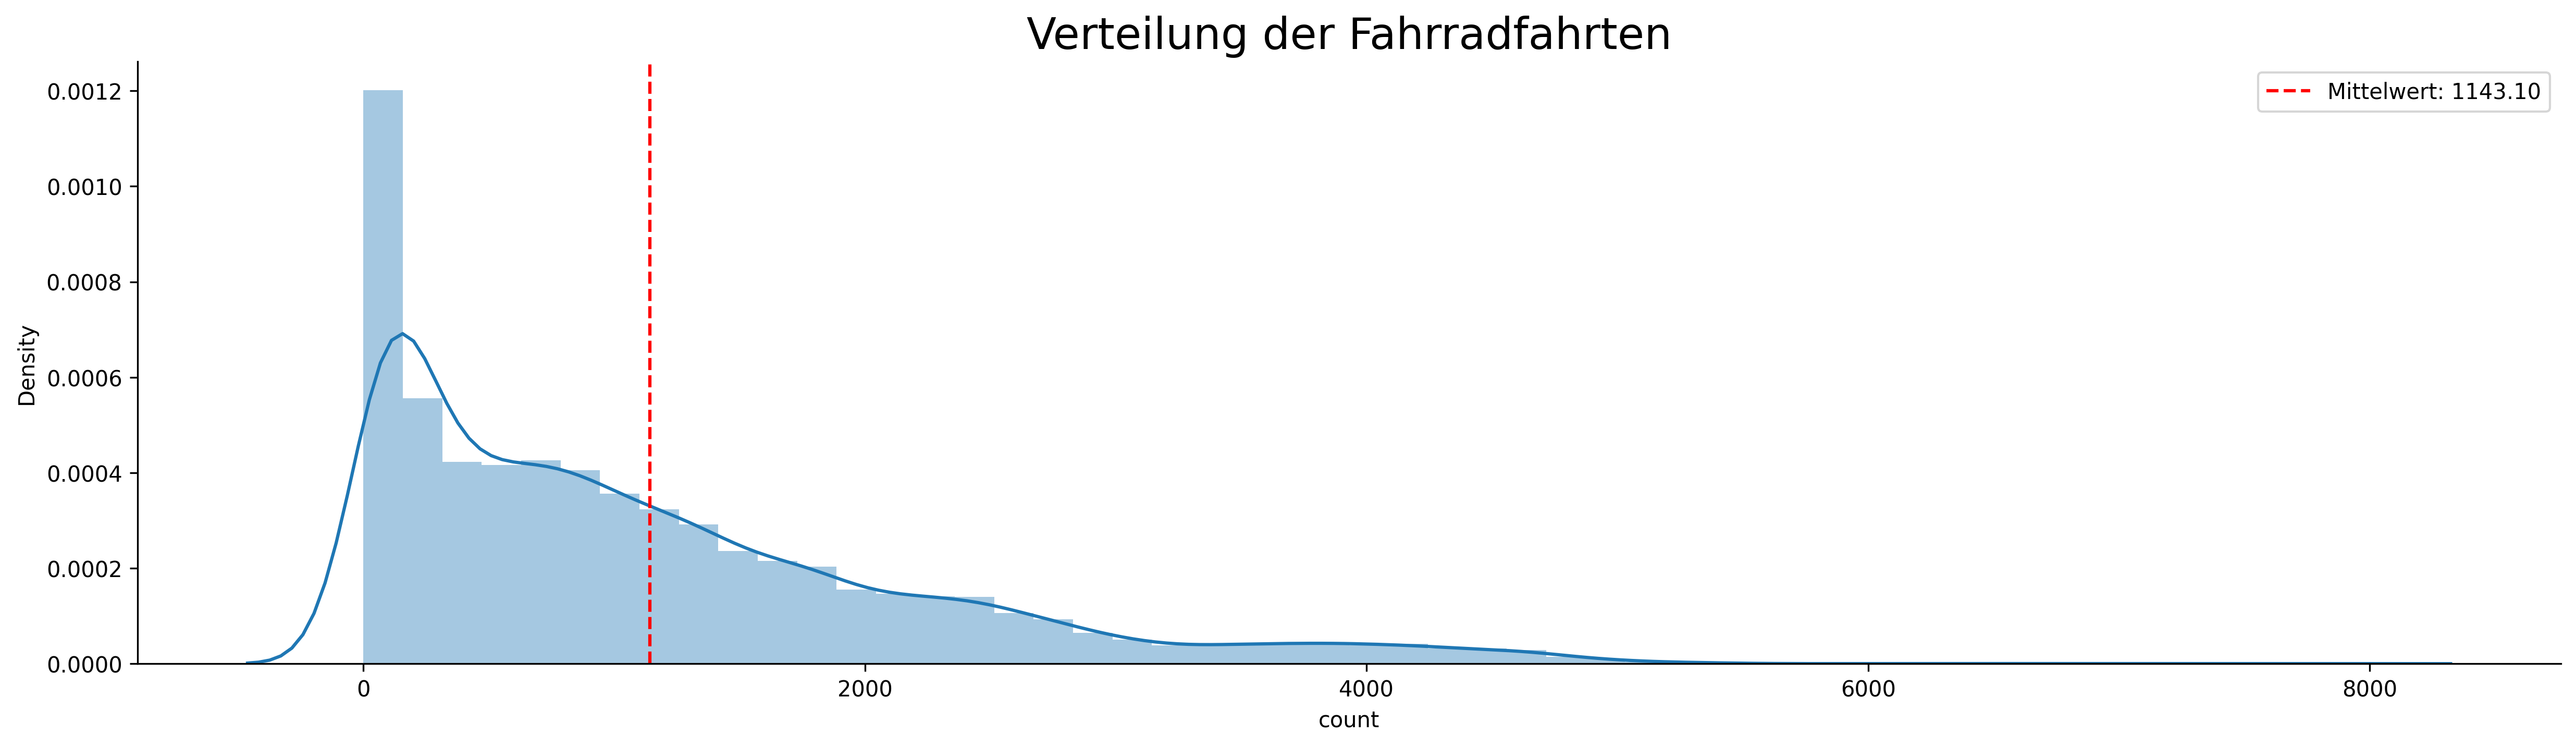

In [234]:
# تعيين حجم الرسم والدقة
plt.figure(figsize=(20, 5), dpi=300)

# إنشاء الرسم البياني لتوزيع عدد ركوب الدراجات
sns.distplot(df_bike["count"])

# تعيين العنوان باللغة الألمانية
plt.title("Verteilung der Fahrradfahrten", fontsize=20)

# إزالة الحواف العلوية واليمنى من الرسم البياني
sns.despine(top=True)

# إضافة خط متوسط القيمة بشكل متقطع
mean_count = df_bike["count"].mean()
plt.axvline(mean_count, ls="--", color="red", label=f"Mittelwert: {mean_count:.2f}")
plt.legend()

# إظهار الرسم البياني
plt.show()

Im obigen Diagramm ist zu erkennen, dass zu bestimmten Zeiten eine große Anzahl von Fahrrädern gleichzeitig geteilt wird (mehr als 4.800 Fahrräder). Solche Phänomene sind sehr selten, und Daten, die sich auf sie beziehen, sollten als Ausreißer betrachtet und daher vor dem Training eines Modells entfernt werden.

Bevor Daten aus dem Datensatz entfernt werden, sollte festgestellt werden, ob solche Anomalien mit bestimmten Tagen oder Ereignissen zusammenhängen (Datenanalyse).

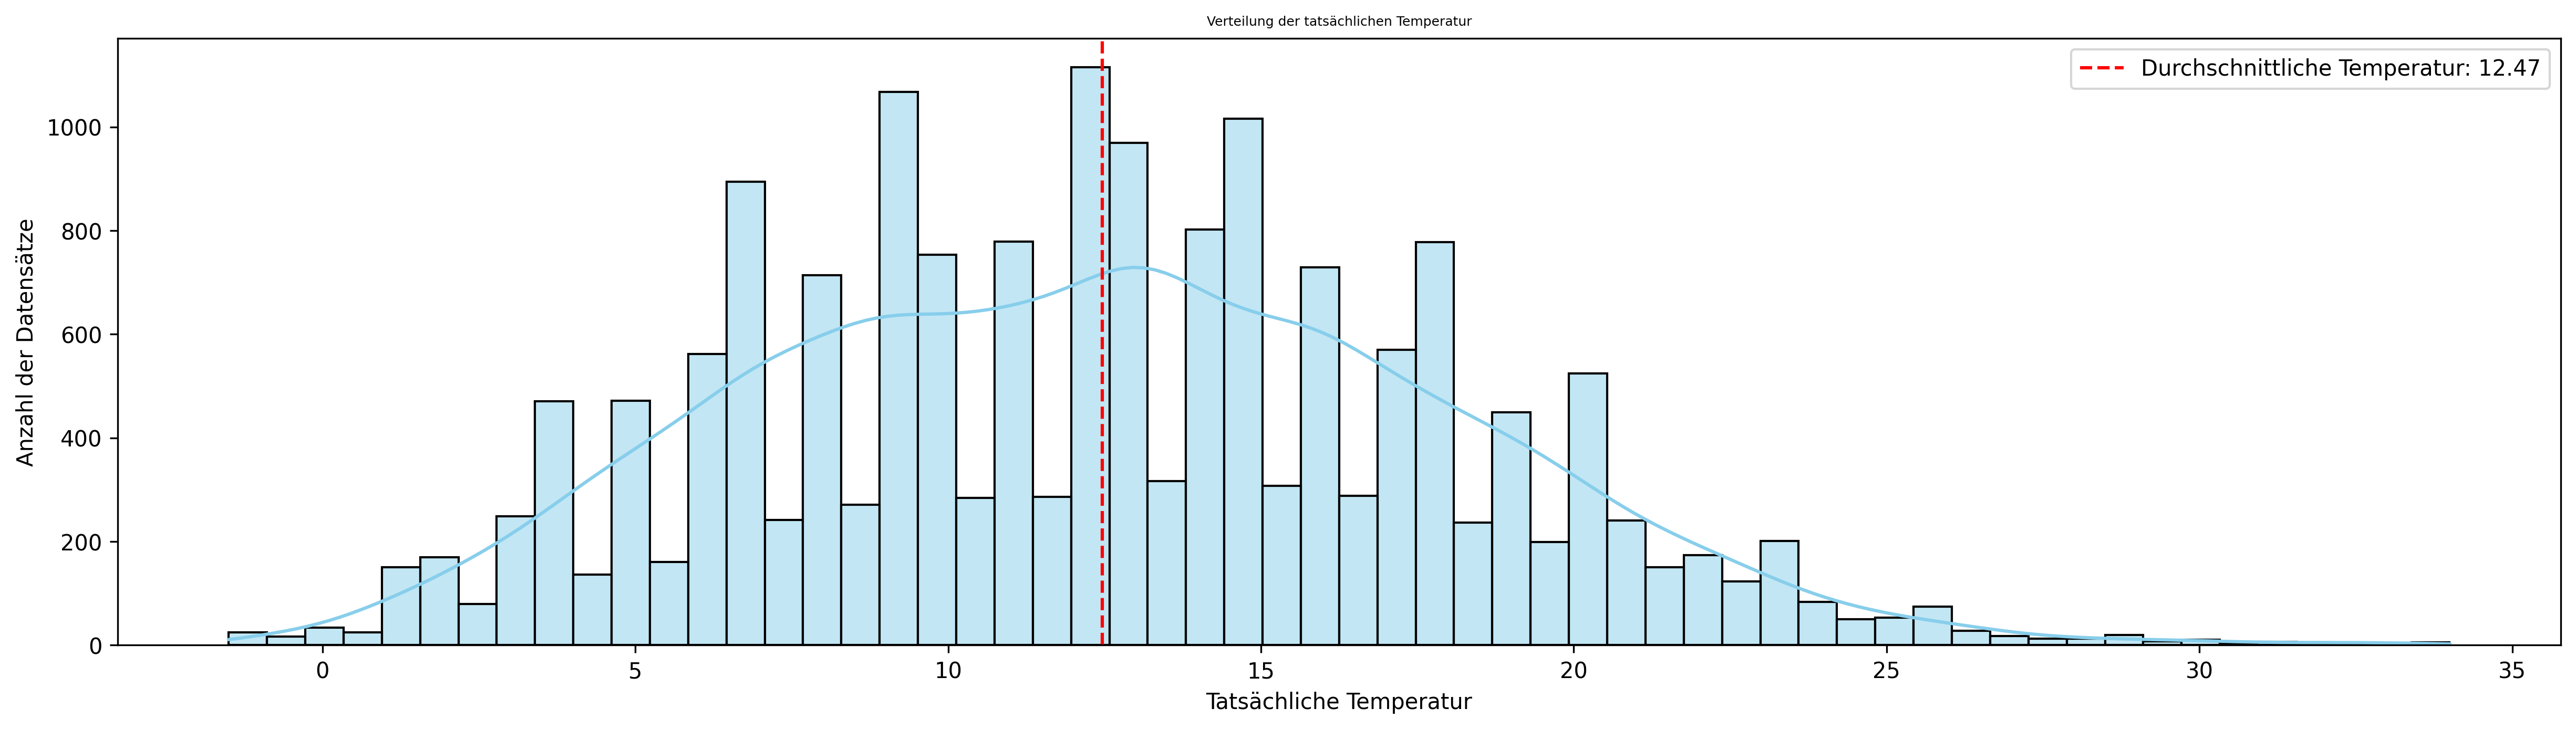

In [235]:
plt.figure(figsize=(20, 5), dpi=300)
sns.histplot(data=df_bike, x="temp", kde=True, color="skyblue")
plt.axvline(
    df_bike["temp"].mean(),
    ls="--",
    color="red",
    label=f'Durchschnittliche Temperatur: {df_bike["temp"].mean():.2f}',
)

# Festlegen des Titels und der Achsenbeschriftungen auf Deutsch
plt.title("Verteilung der tatsächlichen Temperatur", fontsize=6)
plt.xlabel("Tatsächliche Temperatur")
plt.ylabel("Anzahl der Datensätze")

# Anzeigen der Legende und des Diagramms
plt.legend()
plt.show()

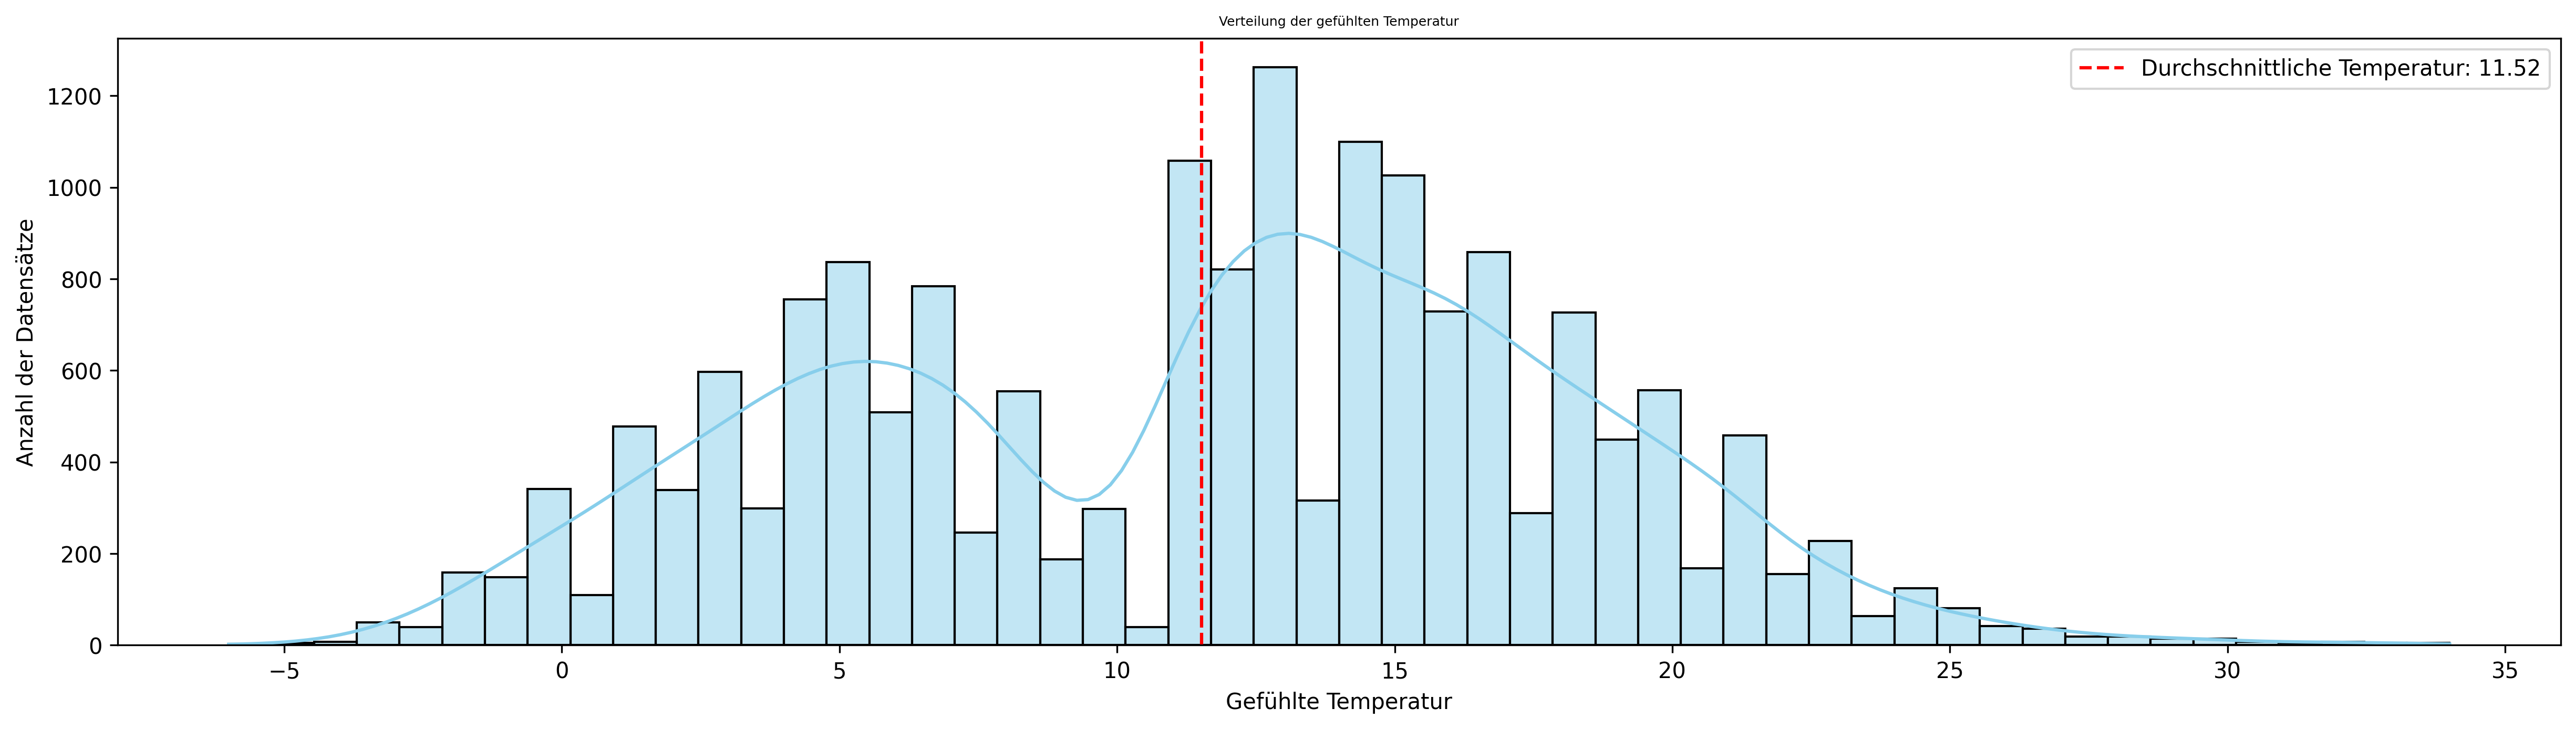

In [236]:
plt.figure(figsize=(20, 5), dpi=300)
sns.histplot(data=df_bike, x="temp_feels_like", kde=True, color="skyblue")
plt.axvline(
    df_bike["temp_feels_like"].mean(),
    ls="--",
    color="red",
    label=f'Durchschnittliche Temperatur: {df_bike["temp_feels_like"].mean():.2f}',
)

# Festlegen des Titels und der Achsenbeschriftungen auf Deutsch
plt.title("Verteilung der gefühlten Temperatur", fontsize=6)
plt.xlabel("Gefühlte Temperatur")
plt.ylabel("Anzahl der Datensätze")

# Anzeigen der Legende und des Diagramms
plt.legend()
plt.show()

Die Grafik der tatsächlichen Temperatur ist entspricht annähernd einer Normalverteilung.
Die Grafik der gefühlten Temperatur entspricht teilweise auch einer Normalverteilung, wobei im Bereich zwischen 6 und 12 °C ein Einbruch vorliegt. Es ist unklar, warum eine gefühlte Temperatur in diesem Bereich seltener vorkommt.
Die sehr fluktuierende Höhe der Balken lässt sich dadurch erklären, dass ganzzahlige Temperaturen deutlich häufiger vorkommen als Temperaturen wie "10,5" oder "11,5". Wahrscheinlich werden einige Temperaturen in den Wetterdaten auf ganzzahlige Werte gerundet.

C:\Users\Hend\AppData\Local\Temp\ipykernel_5152\2493054098.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(df_bike["humidity"])


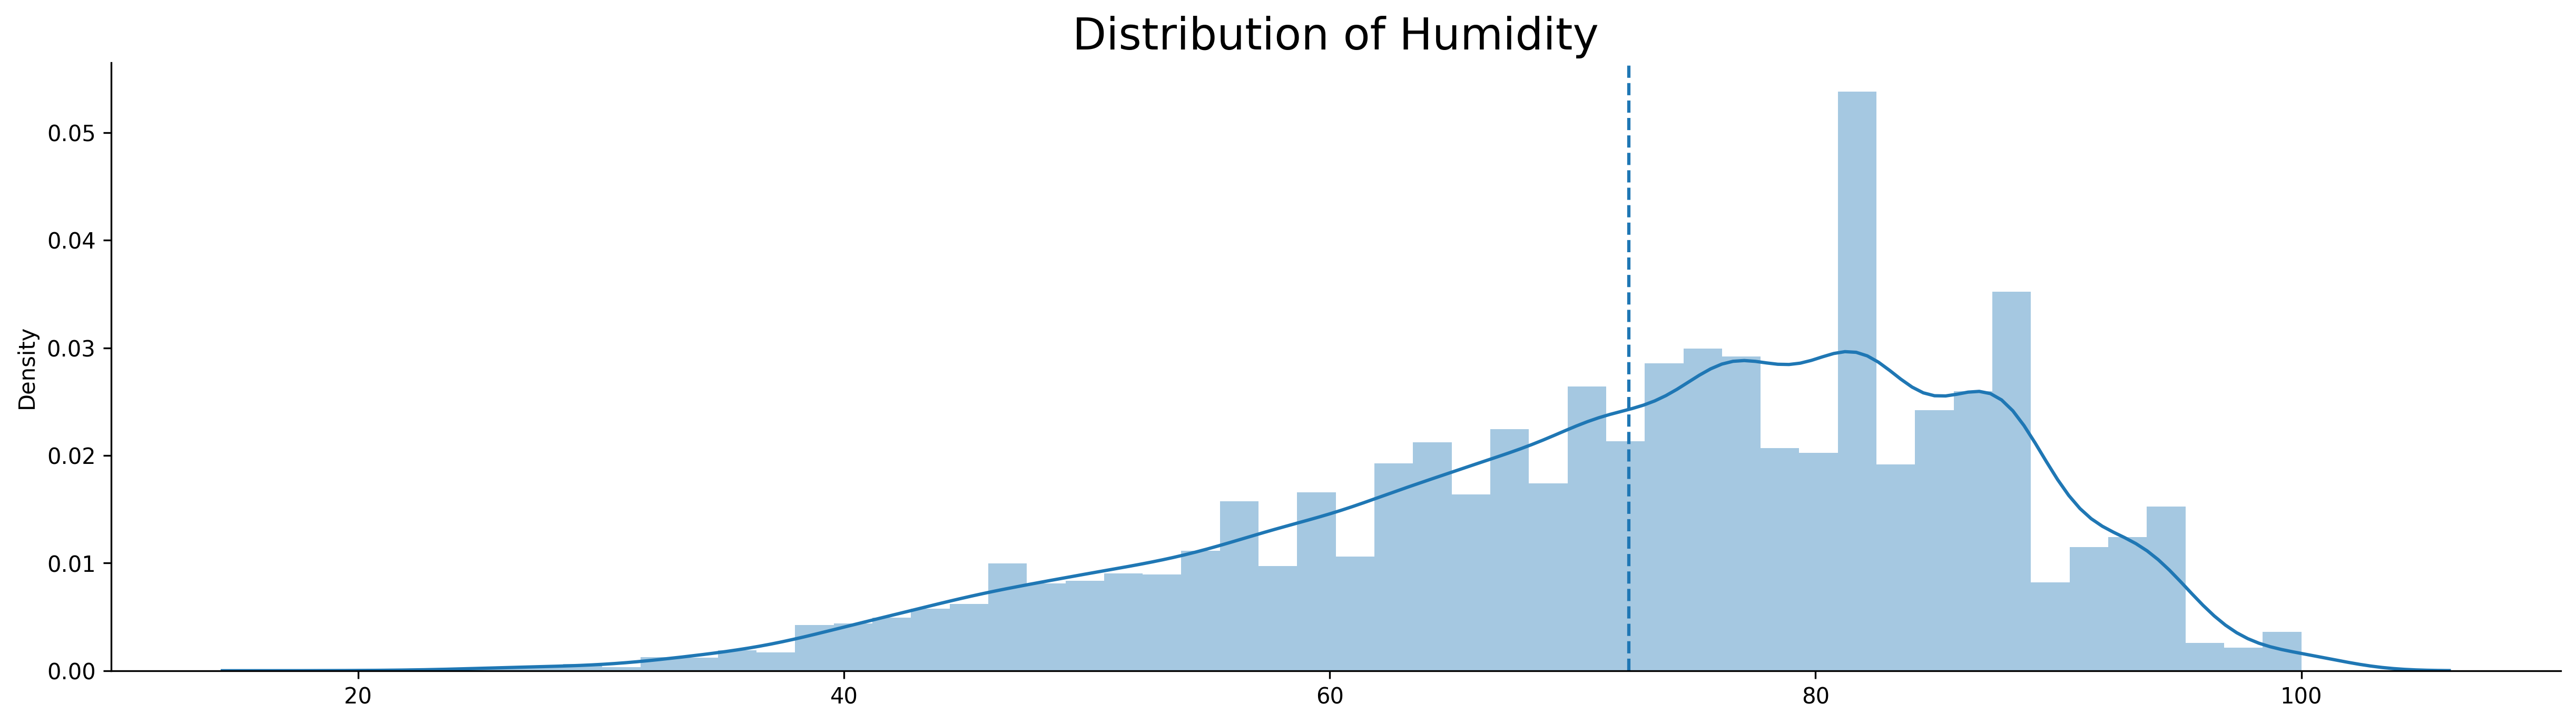

In [237]:
plt.figure(figsize=(20, 5), dpi=300)
fig = sns.distplot(df_bike["humidity"])
plt.xlabel("", fontsize=15)
plt.title("Distribution of Humidity", fontsize=20)
sns.despine(top=True)
plt.axvline(df_bike["humidity"].mean(), ls="--")

C:\Users\Hend\AppData\Local\Temp\ipykernel_5152\3325912933.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(data=df_bike, x="time", y="count", palette="deep")


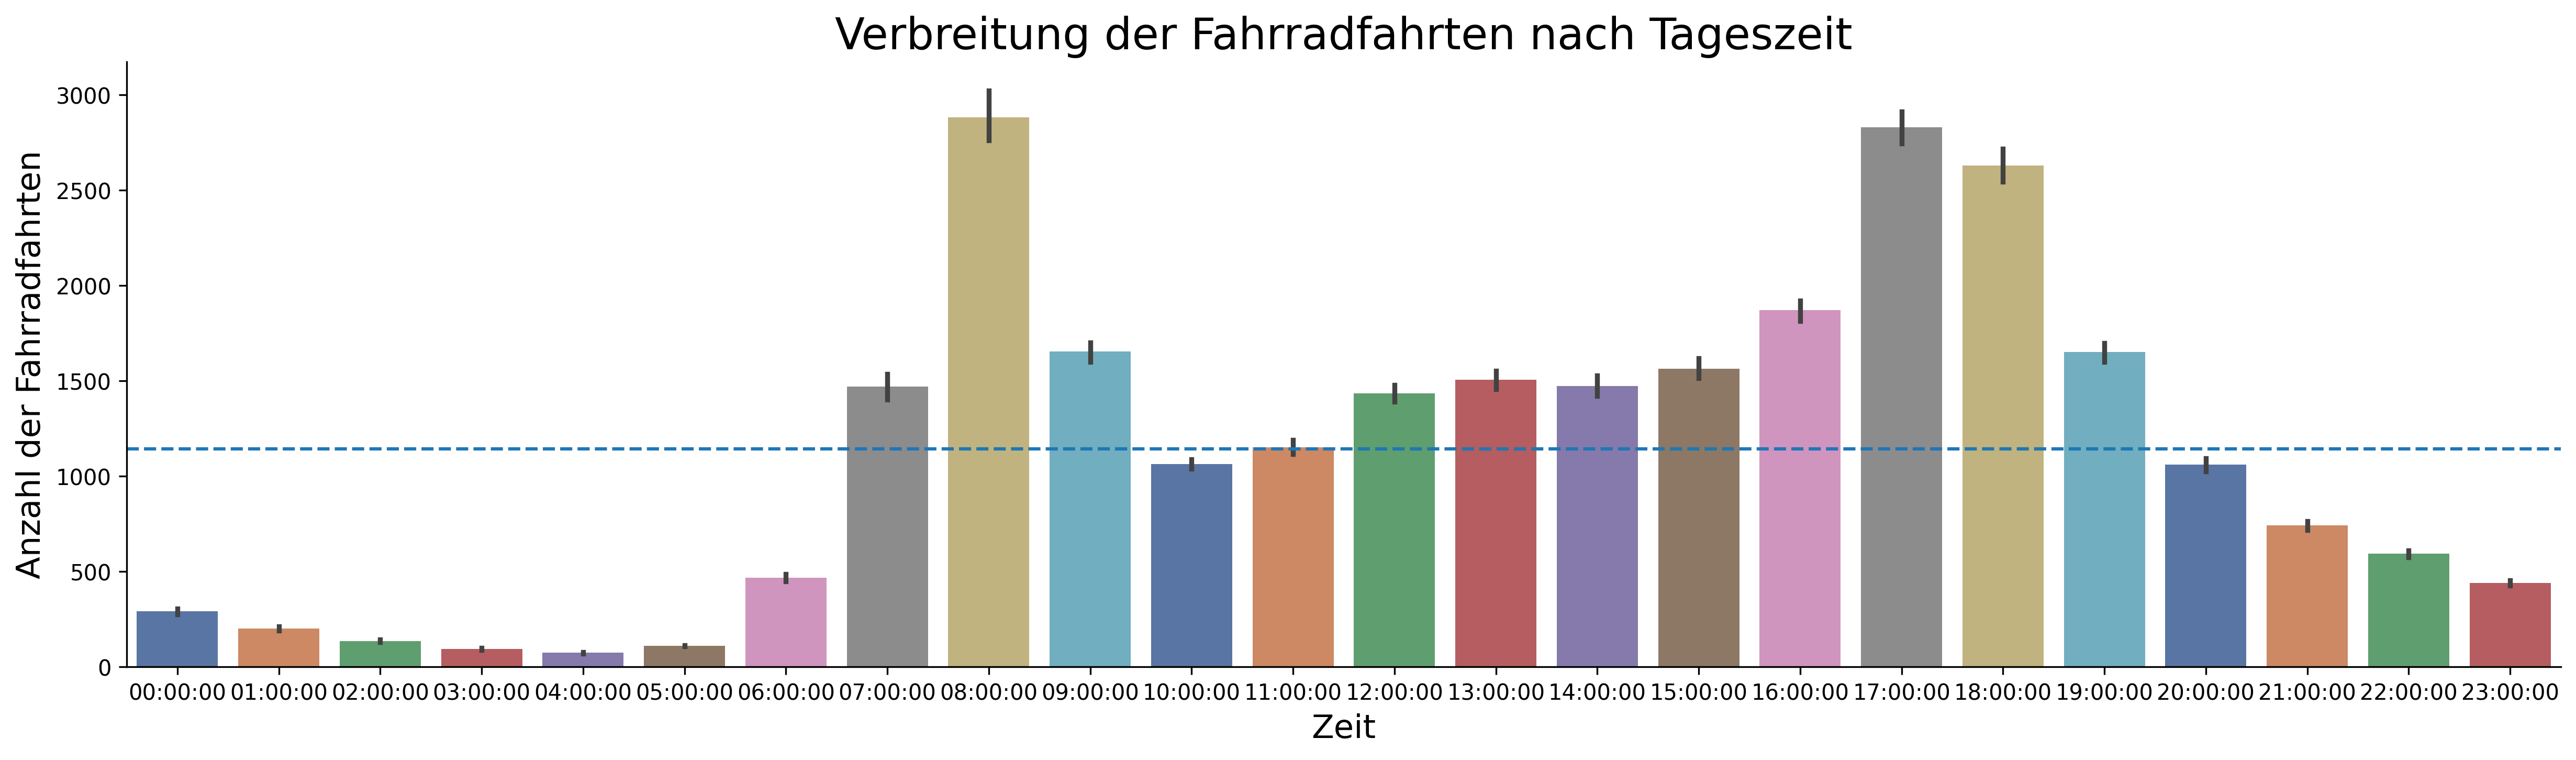

In [238]:
plt.figure(figsize=(20, 5), dpi=300)
fig = sns.barplot(data=df_bike, x="time", y="count", palette="deep")
plt.xlabel("Zeit", fontsize=15)
plt.ylabel("Anzahl der Fahrradfahrten", fontsize=15)
plt.title("Verbreitung der Fahrradfahrten nach Tageszeit", fontsize=20)
sns.despine(top=True)
plt.axhline(df_bike["count"].sum() / len(df_bike), ls="--")

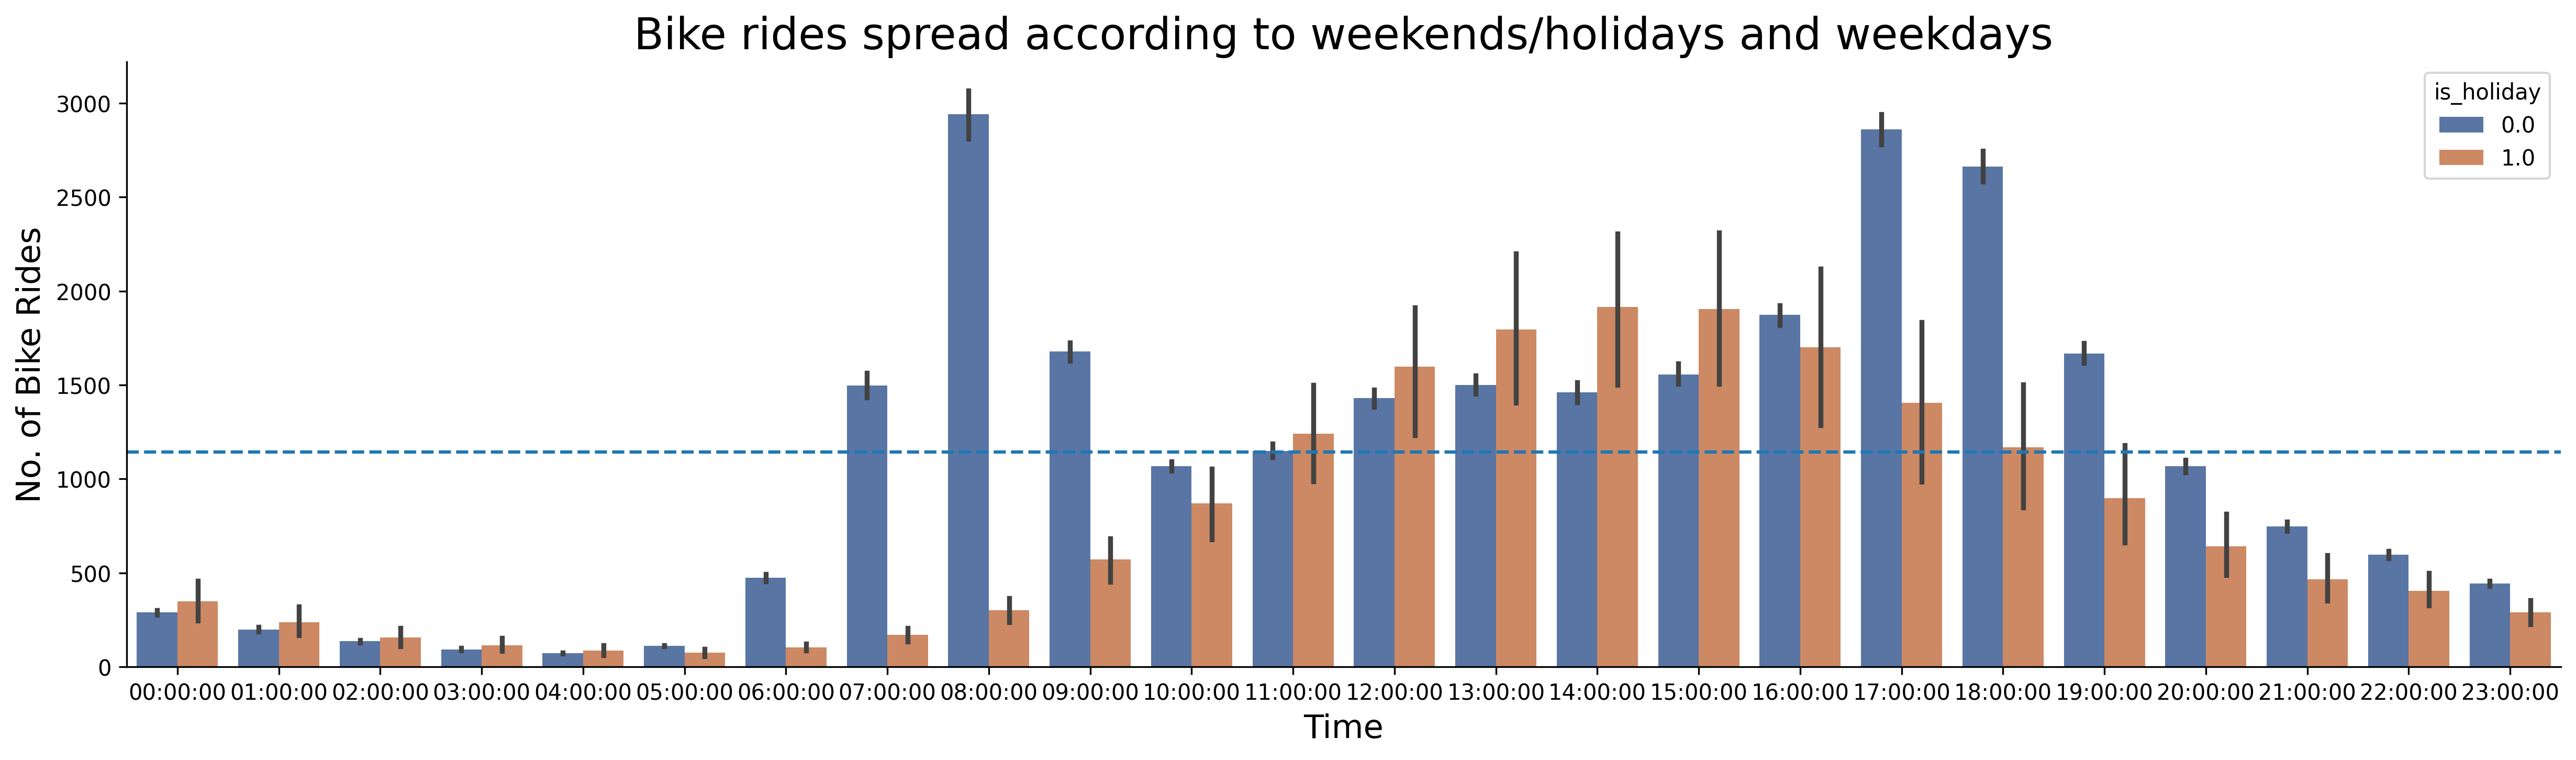

In [239]:
plt.figure(figsize=(20, 5), dpi=300)
fig = sns.barplot(data=df_bike, x="time", y="count", hue="is_holiday", palette="deep")
plt.xlabel("Time", fontsize=15)
plt.ylabel("No. of Bike Rides", fontsize=15)
plt.title("Bike rides spread according to weekends/holidays and weekdays", fontsize=20)
sns.despine(top=True)
plt.axhline(df_bike["count"].sum() / len(df_bike), ls="--")

In [240]:
df_bike

timestamp  count  temp  temp_feels_like  humidity  wind_speed  \
0     2015-01-04 00:00:00    182   3.0              2.0      93.0         6.0   
1     2015-01-04 01:00:00    138   3.0              2.5      93.0         5.0   
2     2015-01-04 02:00:00    134   2.5              2.5      96.5         0.0   
3     2015-01-04 03:00:00     72   2.0              2.0     100.0         0.0   
4     2015-01-04 04:00:00     47   2.0              0.0      93.0         6.5   
...                   ...    ...   ...              ...       ...         ...   
17409 2017-01-03 19:00:00   1042   5.0              1.0      81.0        19.0   
17410 2017-01-03 20:00:00    541   5.0              1.0      81.0        21.0   
17411 2017-01-03 21:00:00    337   5.5              1.5      78.5        24.0   
17412 2017-01-03 22:00:00    224   5.5              1.5      76.0        23.0   
17413 2017-01-03 23:00:00    139   5.0              1.0      76.0        22.0   

       weather_code  is_holiday  is_weekend  season  year    month      time  \
0               3.0         0.0         1.0     3.0  2015  January  00:00:00   
1               1.0         0.0         1.0     3.0  2015  January  01:00:00   
2               1.0         0.0         1.0     3.0  2015  January  02:00:00   
3               1.0         0.0         1.0     3.0  2015  January  03:00:00   
4               1.0         0.0         1.0     3.0  2015  January  04:00:00   
...             ...         ...         ...     ...   ...      ...       ...   
17409           3.0         0.0         0.0     3.0  2017  January  19:00:00   
17410           4.0         0.0         0.0     3.0  2017  January  20:00:00   
17411           4.0         0.0         0.0     3.0  2017  January  21:00:00   
17412           4.0         0.0         0.0     3.0  2017  January  22:00:00   
17413           2.0         0.0         0.0     3.0  2017  January  23:00:00   

      day_of_week season_name         day  
0          Sunday      Winter  2015-01-04  
1          Sunday      Winter  2015-01-04  
2          Sunday      Winter  2015-01-04  
3          Sunday      Winter  2015-01-04  
4          Sunday      Winter  2015-01-04  
...           ...         ...         ...  
17409     Tuesday      Winter  2017-01-03  
17410     Tuesday      Winter  2017-01-03  
17411     Tuesday      Winter  2017-01-03  
17412     Tuesday      Winter  2017-01-03  
17413     Tuesday      Winter  2017-01-03  

[17414 rows x 16 columns]

C:\Users\Hend\AppData\Local\Temp\ipykernel_5152\2790192193.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(data=df_bike, x="month", y="count", palette="deep")


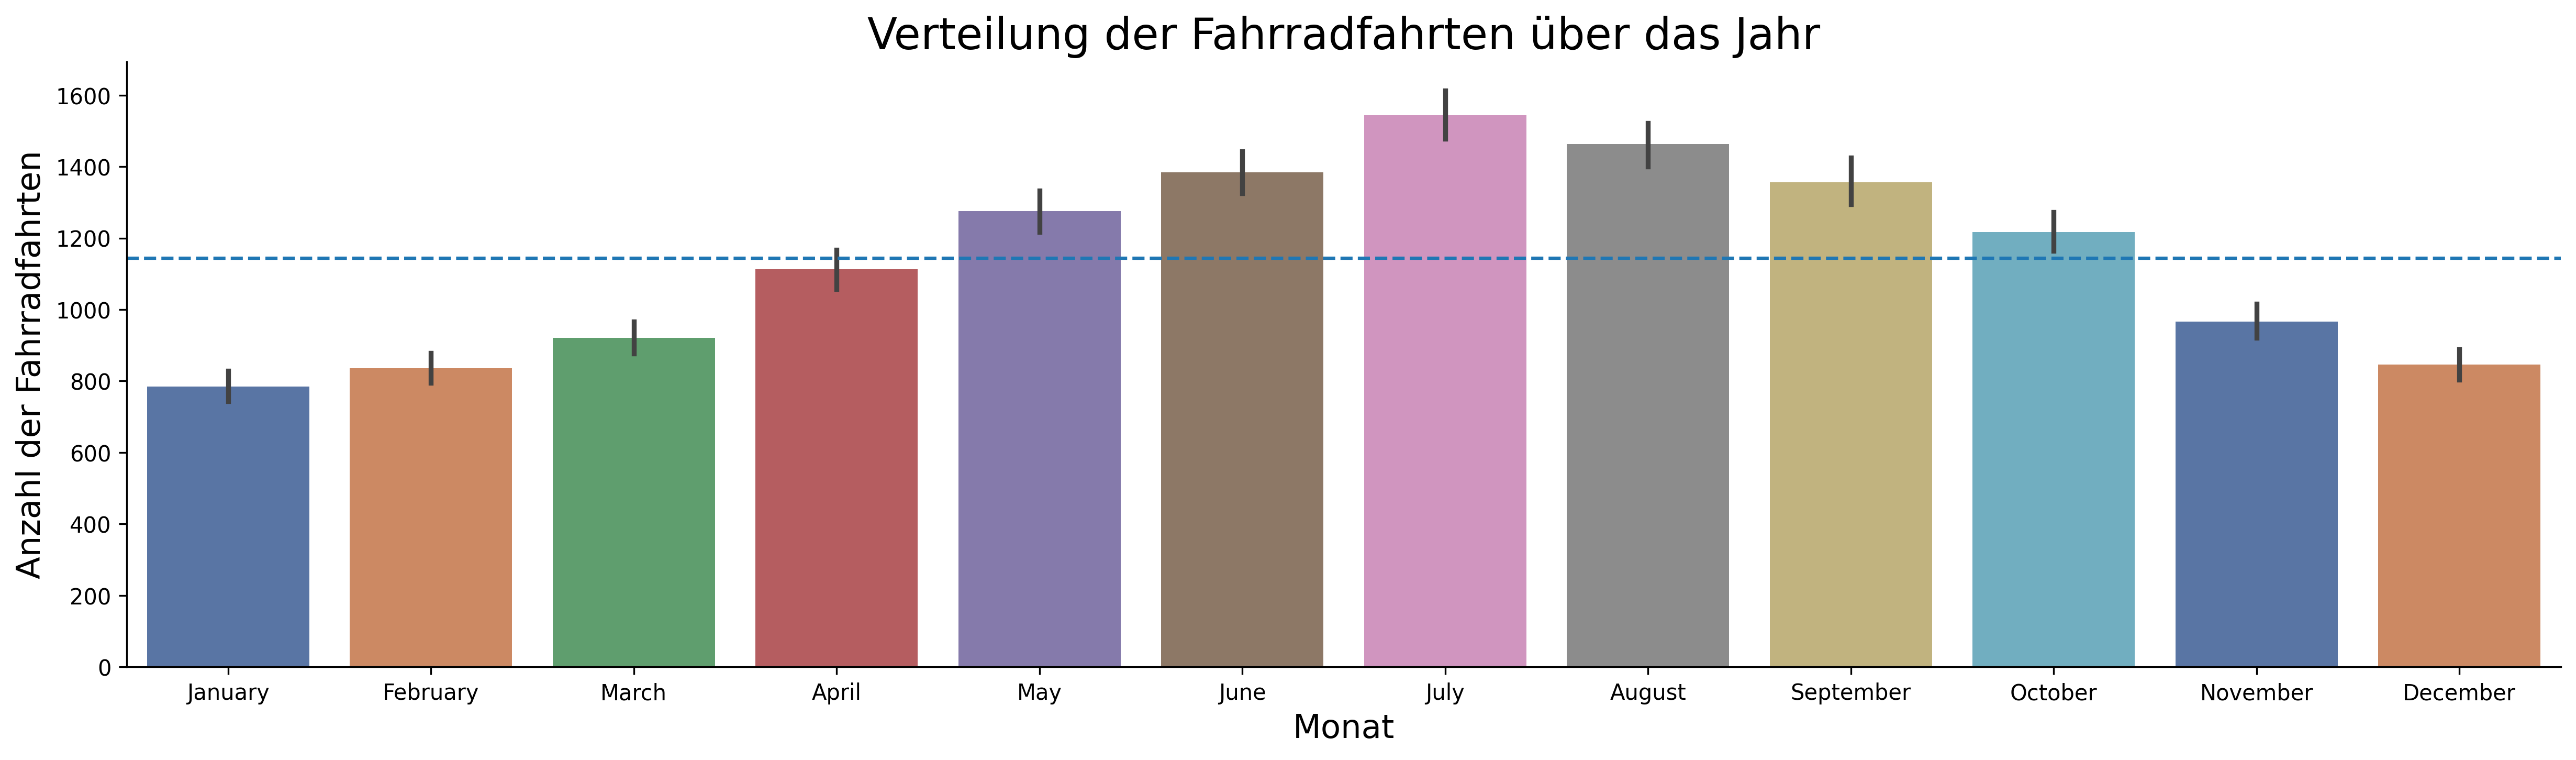

In [241]:
plt.figure(figsize=(20, 5), dpi=300)
fig = sns.barplot(data=df_bike, x="month", y="count", palette="deep")
plt.xlabel("Monat", fontsize=15)
plt.ylabel("Anzahl der Fahrradfahrten", fontsize=15)
plt.title("Verteilung der Fahrradfahrten über das Jahr", fontsize=20)

# إزالة الحواف العلوية
sns.despine(top=True)
# إضافة خط للقيمة المتوسطة
plt.axhline(df_bike["count"].sum() / len(df_bike), ls="--")
# إظهار الرسم البياني
plt.show()

C:\Users\Hend\AppData\Local\Temp\ipykernel_5152\481837577.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(


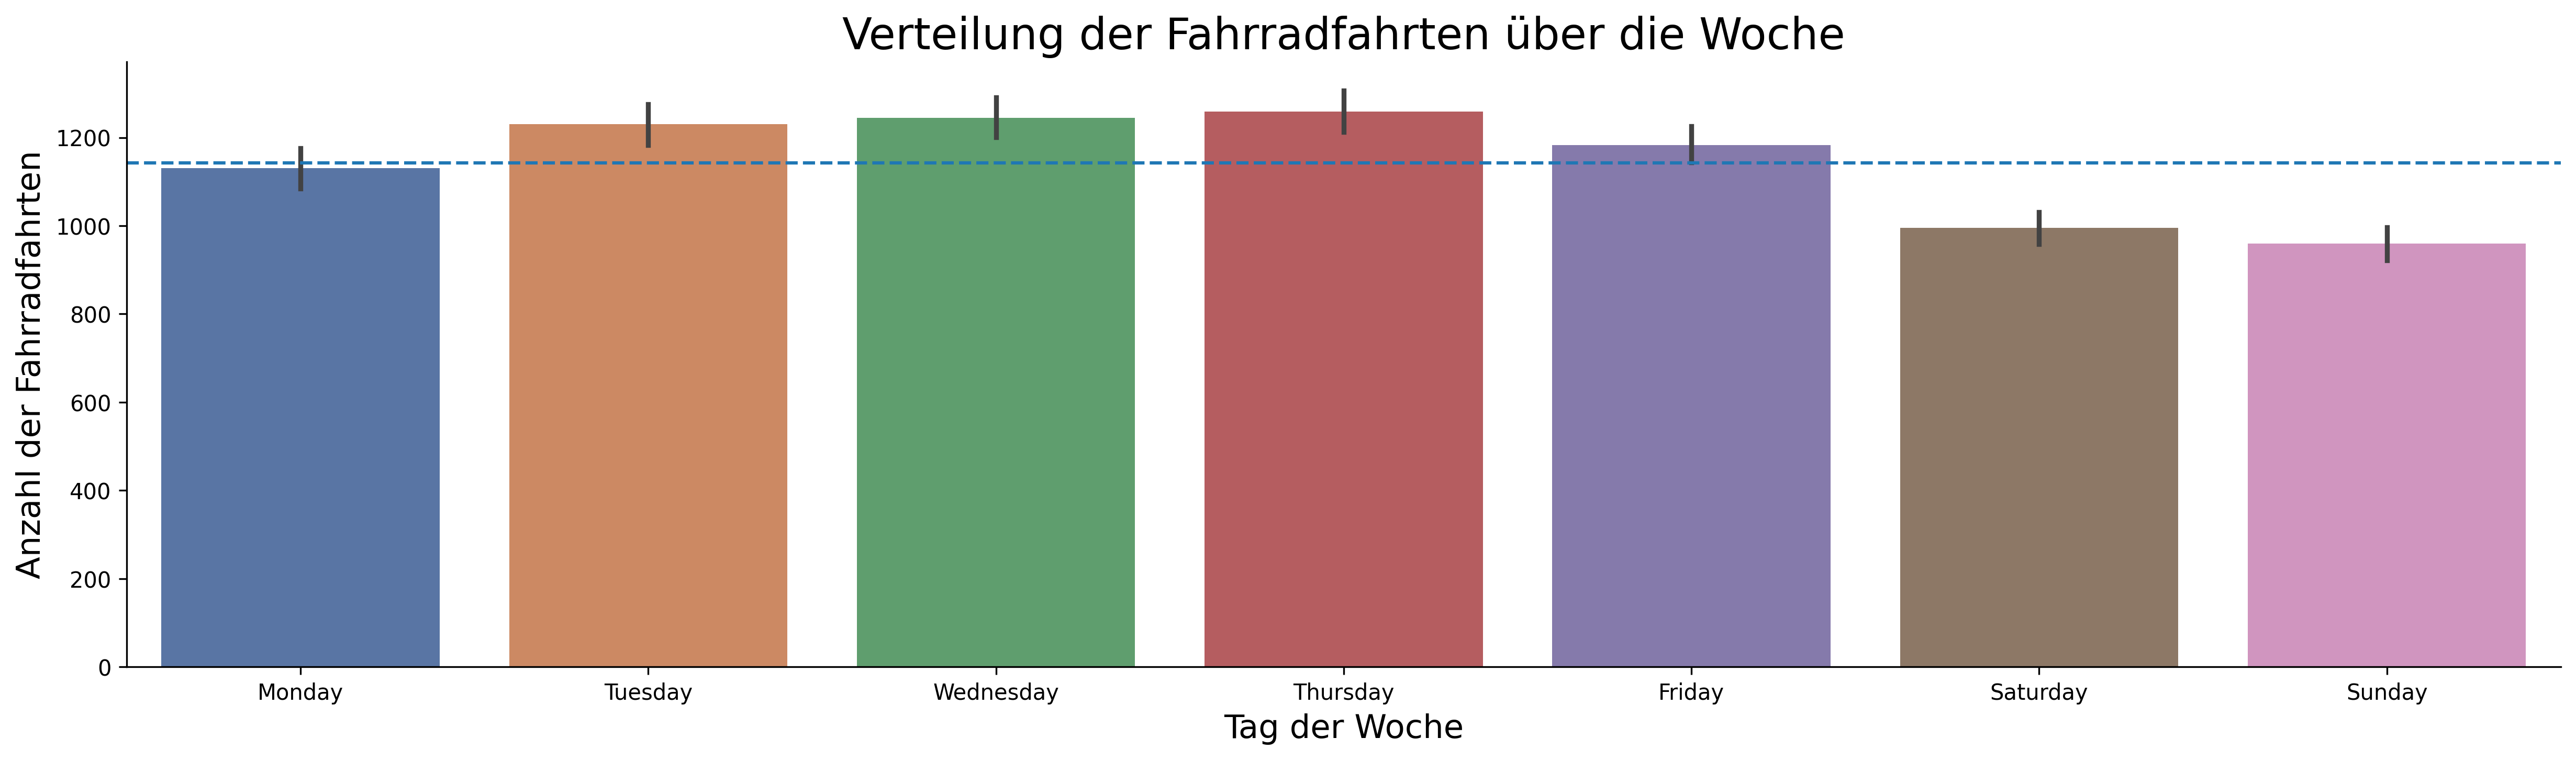

In [242]:
plt.figure(figsize=(20, 5), dpi=300)

# إنشاء الرسم البياني
fig = sns.barplot(
    data=df_bike,
    x="day_of_week",
    y="count",
    palette="deep",
    order=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
)

# تعيين التسميات
plt.xlabel("Tag der Woche", fontsize=15)
plt.ylabel("Anzahl der Fahrradfahrten", fontsize=15)
plt.title("Verteilung der Fahrradfahrten über die Woche", fontsize=20)


# إزالة الحواف العلوية
sns.despine(top=True)

# إضافة خط للقيمة المتوسطة
plt.axhline(df_bike["count"].sum() / len(df_bike), ls="--")

# إظهار الرسم البياني
plt.show()

C:\Users\Hend\AppData\Local\Temp\ipykernel_5152\1082815509.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(


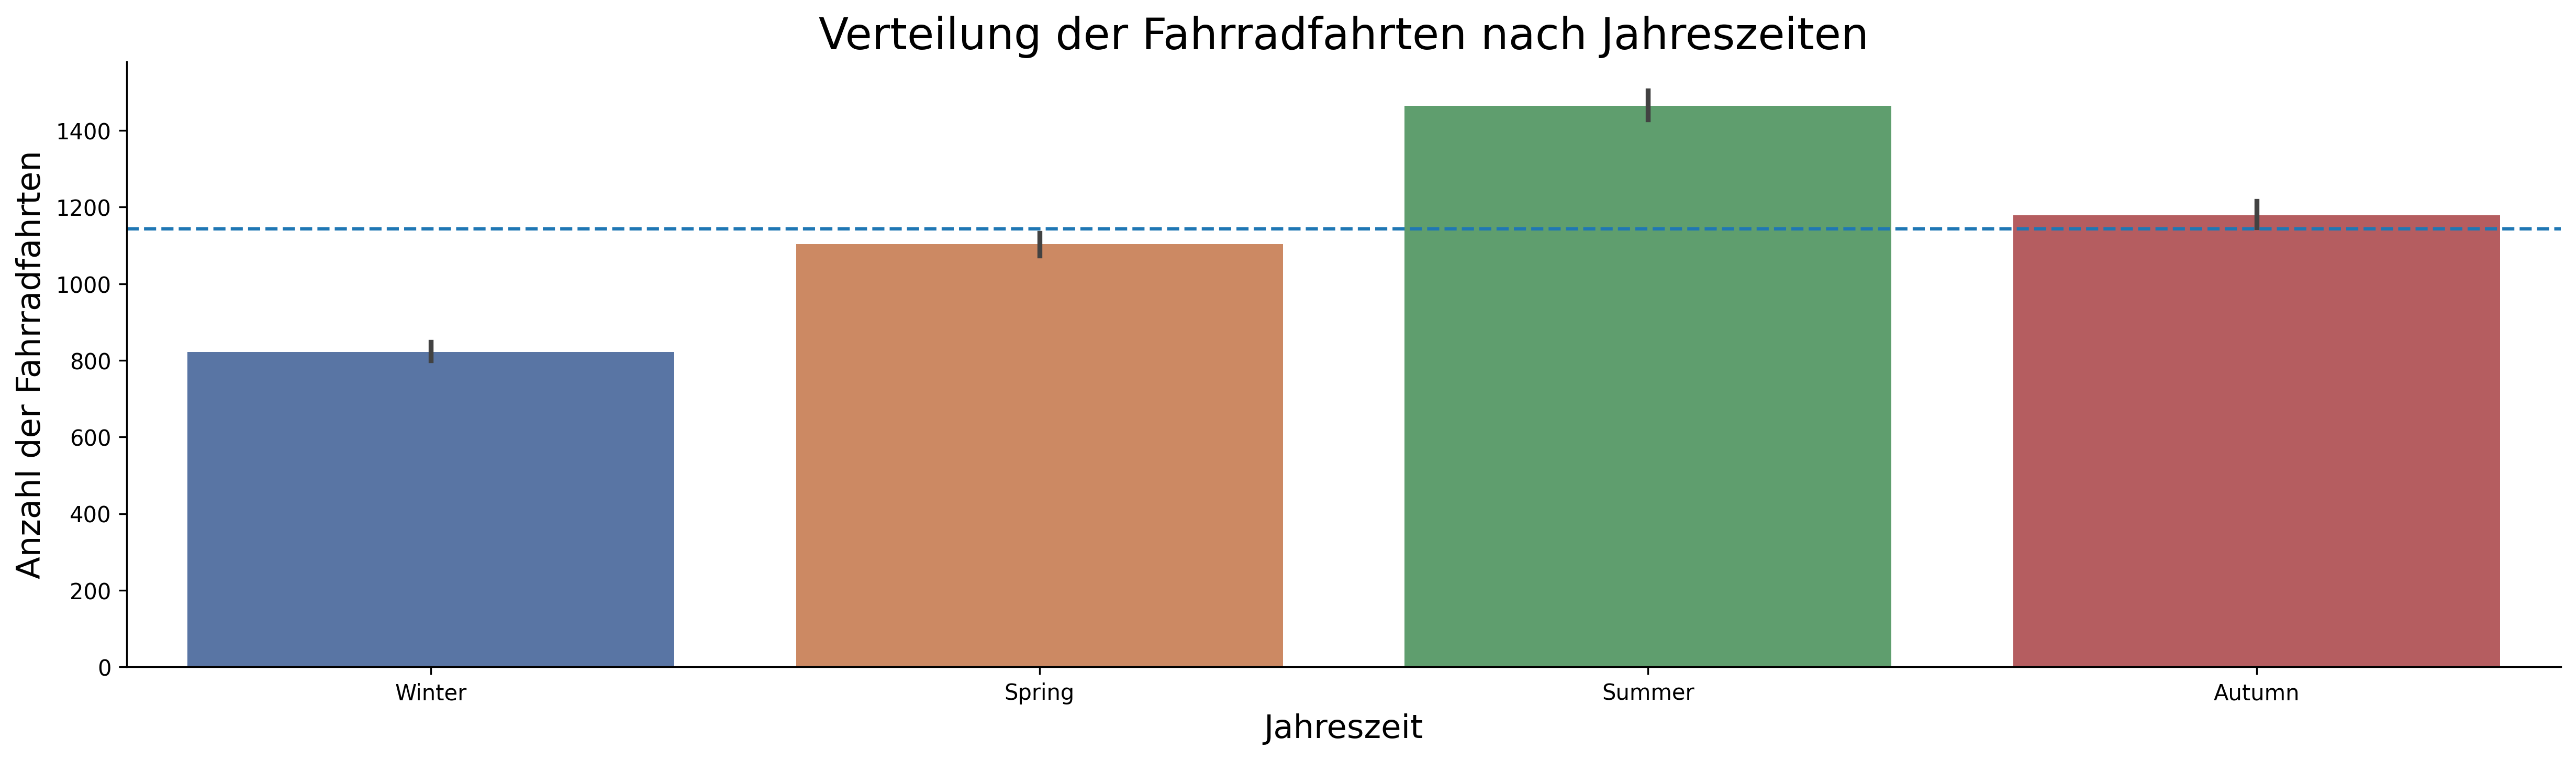

In [243]:
plt.figure(figsize=(20, 5), dpi=300)

# إنشاء الرسم البياني
fig = sns.barplot(
    data=df_bike,
    x="season_name",
    y="count",
    palette="deep",
)

# تعيين التسميات
plt.xlabel("Jahreszeit", fontsize=15)
plt.ylabel("Anzahl der Fahrradfahrten", fontsize=15)
plt.title("Verteilung der Fahrradfahrten nach Jahreszeiten", fontsize=20)

# إزالة الحواف العلوية
sns.despine(top=True)

# إضافة خط للقيمة المتوسطة
plt.axhline(df_bike["count"].sum() / len(df_bike), ls="--")

# إظهار الرسم البياني
plt.show()

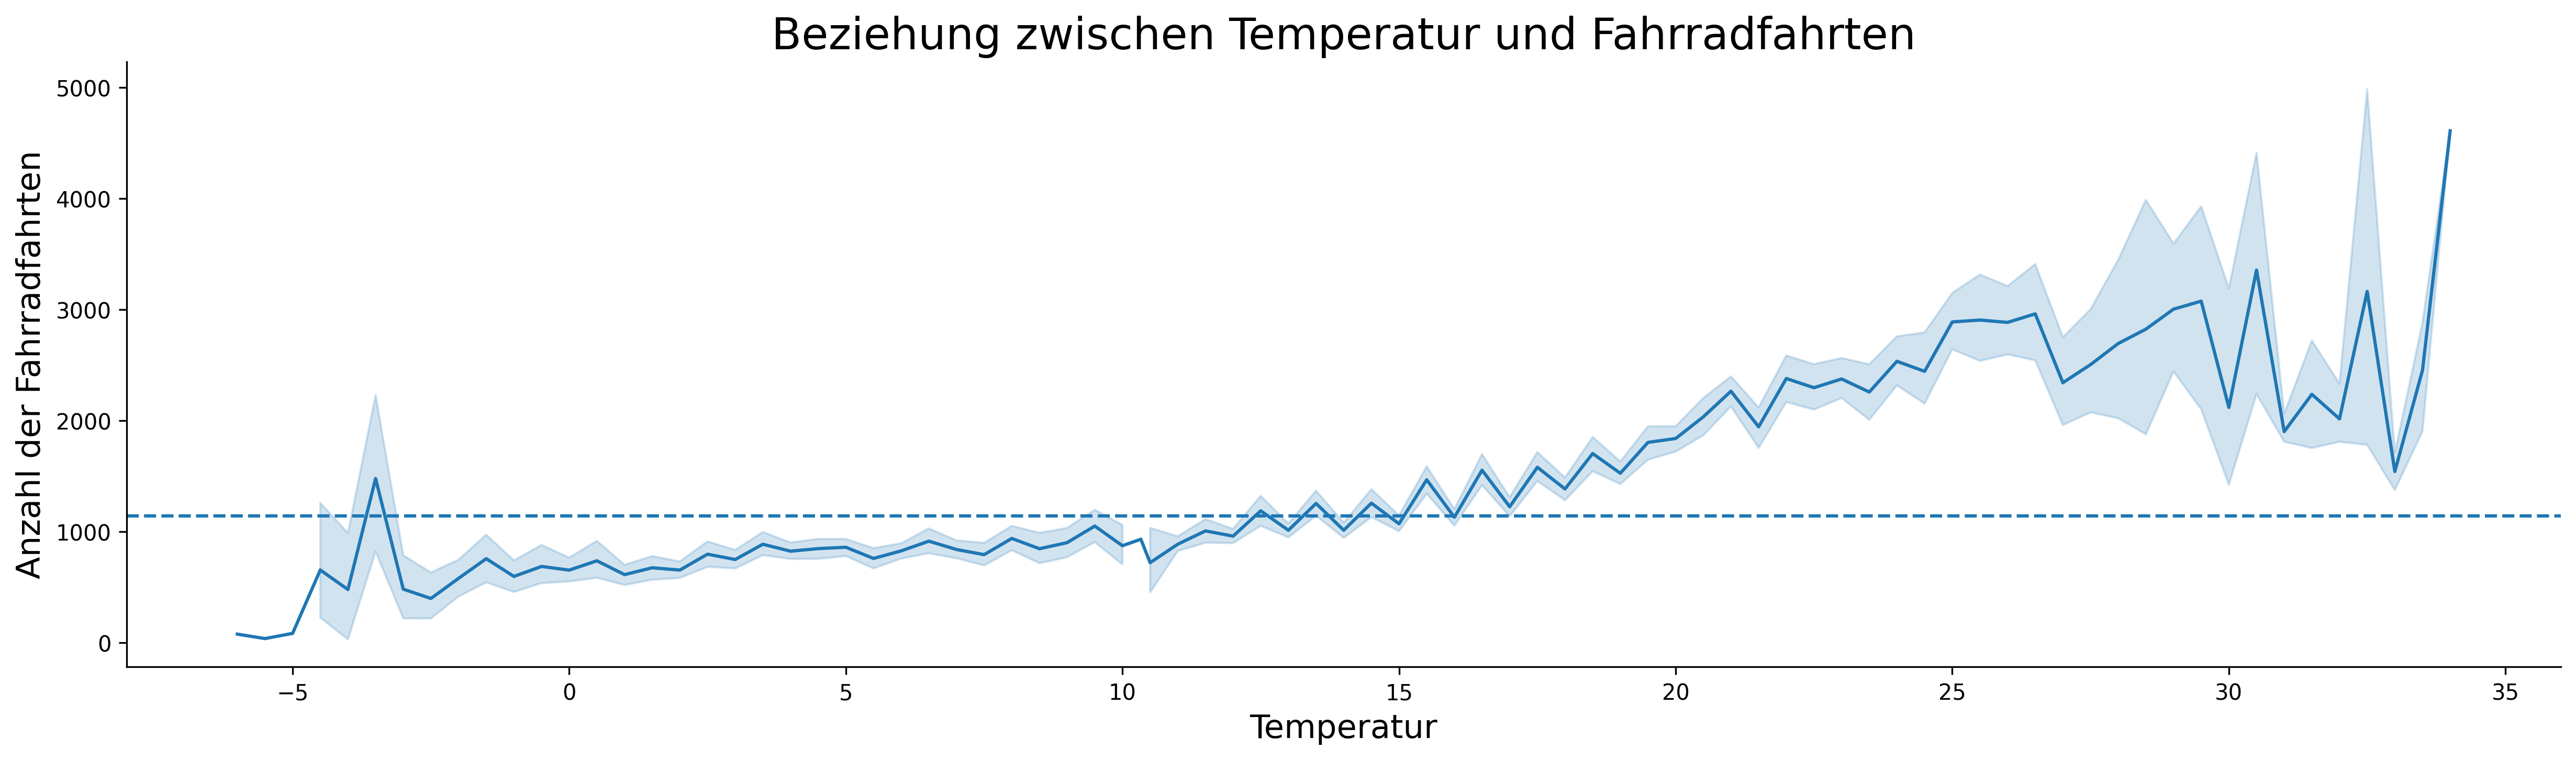

In [244]:
plt.figure(figsize=(20, 5), dpi=300)
fig = sns.lineplot(data=df_bike, x="temp_feels_like", y="count")
plt.xlabel("Temperatur", fontsize=15)
plt.ylabel("Anzahl der Fahrradfahrten", fontsize=15)
plt.title("Beziehung zwischen Temperatur und Fahrradfahrten", fontsize=20)
sns.despine(top=True)
plt.axhline(df_bike["count"].sum() / len(df_bike), ls="--")

Das Durchschnittnehmen der gemeinsam genutzten Fahrräder bei verschiedenen Temperaturaufzeichnungen scheint eine positive Korrelation zwischen beiden Attributen zu zeigen. Die Berechnung der Korrelation zwischen der Anzahl der gemeinsam genutzten Fahrräder und der Temperatur wäre nützlich, um eine solche Hypothese zu überprüfen.

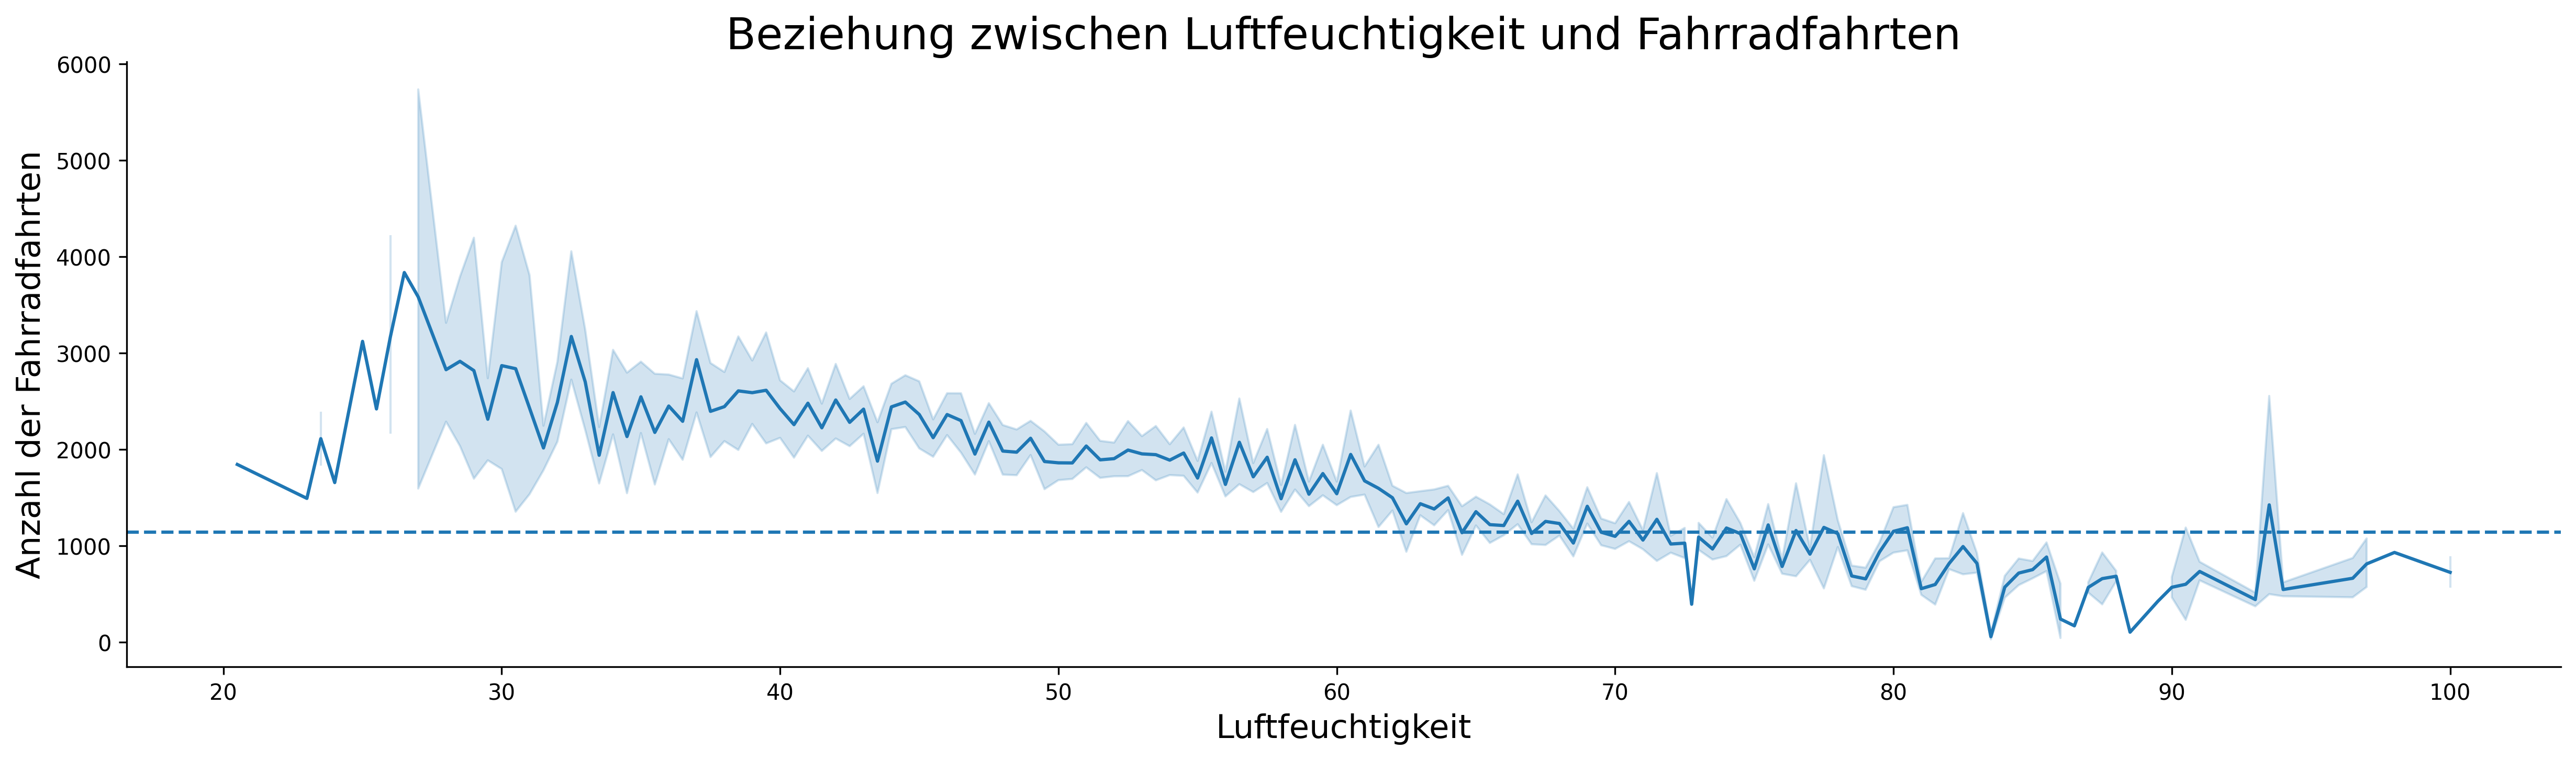

In [245]:
plt.figure(figsize=(20, 5), dpi=300)
fig = sns.lineplot(data=df_bike, x="humidity", y="count")
plt.xlabel("Luftfeuchtigkeit", fontsize=15)
plt.ylabel("Anzahl der Fahrradfahrten", fontsize=15)
plt.title("Beziehung zwischen Luftfeuchtigkeit und Fahrradfahrten", fontsize=20)
sns.despine(top=True)
plt.axhline(df_bike["count"].sum() / len(df_bike), ls="--")

Im Gegensatz zur Temperatur zeigt die Luftfeuchtigkeit eine negative Korrelation mit der Anzahl der gemeinsam genutzten Fahrräder, was bedeutet, dass bei höherer Luftfeuchtigkeit weniger Fahrräder gemeinsam genutzt werden. Dies hängt wahrscheinlich mit Regen zusammen, denn niemand möchte beim Fahrradfahren nass werden.

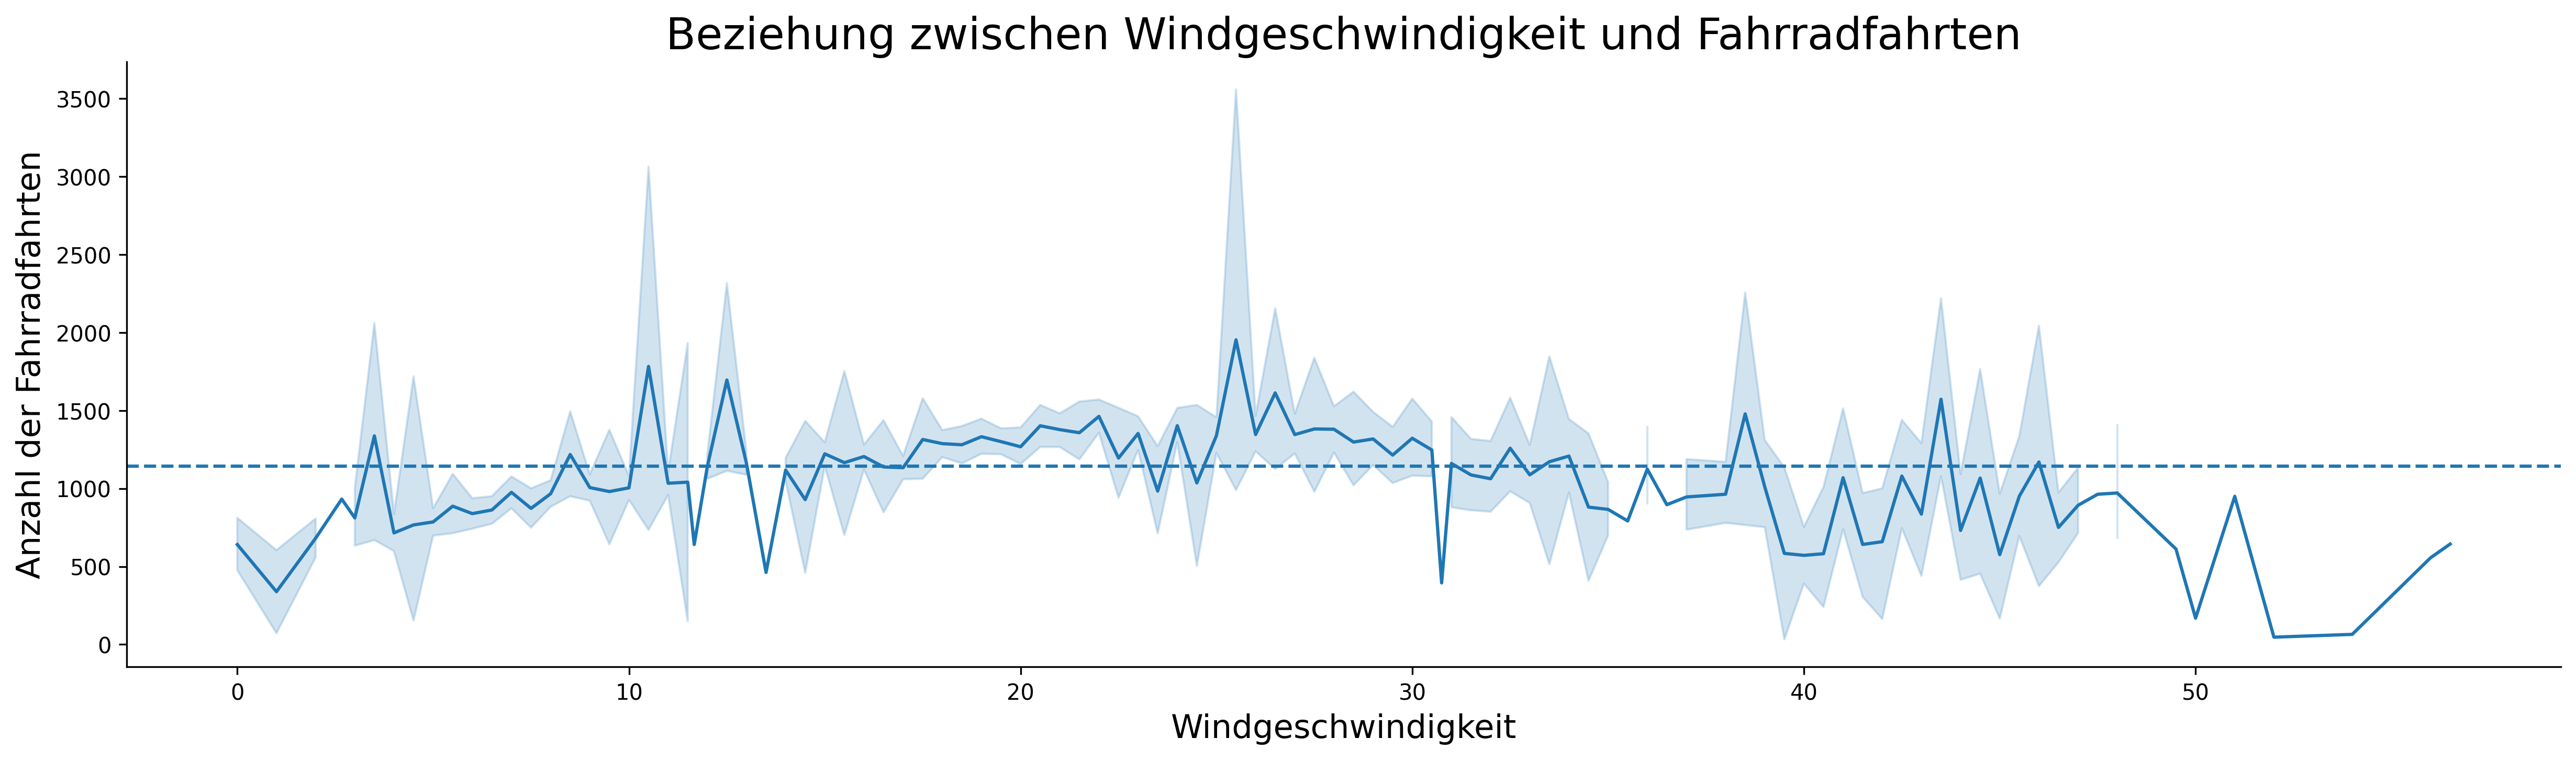

In [246]:
plt.figure(figsize=(20, 5), dpi=300)
fig = sns.lineplot(data=df_bike, x="wind_speed", y="count")
plt.xlabel("Windgeschwindigkeit", fontsize=15)
plt.ylabel("Anzahl der Fahrradfahrten", fontsize=15)
plt.title("Beziehung zwischen Windgeschwindigkeit und Fahrradfahrten", fontsize=20)
sns.despine(top=True)
plt.axhline(df_bike["count"].sum() / len(df_bike), ls="--")

Es gibt keine klare Korrelation zwischen der Anzahl der gemeinsam genutzten Fahrräder und der Windgeschwindigkeit. Offensichtlich sinkt die Anzahl der gemeinsam genutzten Fahrräder, wenn die Windgeschwindigkeit abnimmt, und dasselbe passiert, wenn die Windgeschwindigkeit zunimmt. Möglicherweise kann ein hoher Korrelationswert durch eine nicht-lineare Korrelationsmethode (wie Spearman) gefunden werden.

## Section 3. Data analysis

In [247]:
df_bike.isna().sum()

timestamp          0
count              0
temp               0
temp_feels_like    0
humidity           0
wind_speed         0
weather_code       0
is_holiday         0
is_weekend         0
season             0
year               0
month              0
time               0
day_of_week        0
season_name        0
day                0
dtype: int64

In [248]:
# إنشاء مؤشر لساعة كل صف
hourly_counts = df_bike[df_bike["count"] > 4000].groupby(df_bike["time"]).size()

# عرض النتائج
print(hourly_counts)

time
07:00:00      2
08:00:00    273
09:00:00      1
13:00:00      3
14:00:00      3
15:00:00      6
16:00:00      5
17:00:00    120
18:00:00     99
19:00:00      2
dtype: int64


Wenn man die vorherige Tabelle betrachtet, kann man feststellen, dass die Einträge mit den höchsten Bereichen von geteilten Fahrrädern auf bestimmte Tageszeiten (7:00 - 8:00 Uhr, 17:00 - 18:00 Uhr) bezogen sind, wahrscheinlich die Zeiten, zu denen die Londoner normalerweise zur Schule/Arbeit und nach Hause gehen.

In [249]:
df_bike

timestamp  count  temp  temp_feels_like  humidity  wind_speed  \
0     2015-01-04 00:00:00    182   3.0              2.0      93.0         6.0   
1     2015-01-04 01:00:00    138   3.0              2.5      93.0         5.0   
2     2015-01-04 02:00:00    134   2.5              2.5      96.5         0.0   
3     2015-01-04 03:00:00     72   2.0              2.0     100.0         0.0   
4     2015-01-04 04:00:00     47   2.0              0.0      93.0         6.5   
...                   ...    ...   ...              ...       ...         ...   
17409 2017-01-03 19:00:00   1042   5.0              1.0      81.0        19.0   
17410 2017-01-03 20:00:00    541   5.0              1.0      81.0        21.0   
17411 2017-01-03 21:00:00    337   5.5              1.5      78.5        24.0   
17412 2017-01-03 22:00:00    224   5.5              1.5      76.0        23.0   
17413 2017-01-03 23:00:00    139   5.0              1.0      76.0        22.0   

       weather_code  is_holiday  is_weekend  season  year    month      time  \
0               3.0         0.0         1.0     3.0  2015  January  00:00:00   
1               1.0         0.0         1.0     3.0  2015  January  01:00:00   
2               1.0         0.0         1.0     3.0  2015  January  02:00:00   
3               1.0         0.0         1.0     3.0  2015  January  03:00:00   
4               1.0         0.0         1.0     3.0  2015  January  04:00:00   
...             ...         ...         ...     ...   ...      ...       ...   
17409           3.0         0.0         0.0     3.0  2017  January  19:00:00   
17410           4.0         0.0         0.0     3.0  2017  January  20:00:00   
17411           4.0         0.0         0.0     3.0  2017  January  21:00:00   
17412           4.0         0.0         0.0     3.0  2017  January  22:00:00   
17413           2.0         0.0         0.0     3.0  2017  January  23:00:00   

      day_of_week season_name         day  
0          Sunday      Winter  2015-01-04  
1          Sunday      Winter  2015-01-04  
2          Sunday      Winter  2015-01-04  
3          Sunday      Winter  2015-01-04  
4          Sunday      Winter  2015-01-04  
...           ...         ...         ...  
17409     Tuesday      Winter  2017-01-03  
17410     Tuesday      Winter  2017-01-03  
17411     Tuesday      Winter  2017-01-03  
17412     Tuesday      Winter  2017-01-03  
17413     Tuesday      Winter  2017-01-03  

[17414 rows x 16 columns]

In [250]:
df_bike[df_bike["count"] > 4000].sort_values(by=["count"]).tail()

timestamp  count  temp  temp_feels_like  humidity  wind_speed  \
5129 2015-08-06 08:00:00   6585  19.0             19.0      78.0        12.0   
4471 2015-07-09 18:00:00   6913  22.5             21.5      29.0        13.0   
5138 2015-08-06 17:00:00   7208  22.5             22.5      55.0        17.5   
4461 2015-07-09 08:00:00   7531  14.5             14.5      61.0        19.0   
4470 2015-07-09 17:00:00   7860  23.0             22.0      27.0        11.0   

      weather_code  is_holiday  is_weekend  season  year   month      time  \
5129           7.0         0.0         0.0     1.0  2015  August  08:00:00   
4471           1.0         0.0         0.0     1.0  2015    July  18:00:00   
5138           2.0         0.0         0.0     1.0  2015  August  17:00:00   
4461           2.0         0.0         0.0     1.0  2015    July  08:00:00   
4470           1.0         0.0         0.0     1.0  2015    July  17:00:00   

     day_of_week season_name         day  
5129    Thursday      Summer  2015-08-06  
4471    Thursday      Summer  2015-07-09  
5138    Thursday      Summer  2015-08-06  
4461    Thursday      Summer  2015-07-09  
4470    Thursday      Summer  2015-07-09

"Vielleicht handelt es sich bei diesen Daten um Ereignisse in London, und daher sind sie als Ausreißer zu betrachten, die gelöscht werden sollten. Es muss überprüft werden."



In [251]:
# pd.set_option("display.max_rows", None)

In [252]:
share_bikes = df_bike

share_bikes = share_bikes.groupby(
    [
        "day",
        "month",
        "is_holiday",
        "is_weekend",
    ],
    as_index=False,
)["count"].sum()
mean_day = share_bikes["count"].mean()

print("The mean of shared bikes per day is: " + str(mean_day))

The mean of shared bikes per day is: 27268.45479452055


In [253]:
share_bikes[share_bikes["count"] < mean_day][
    ["day", "month", "count", "is_holiday", "is_weekend"]
].sort_values(by=["count"])

day      month  count  is_holiday  is_weekend
364  2016-01-03    January   4869         0.0         1.0
727  2017-01-01    January   6421         0.0         1.0
363  2016-01-02    January   7195         0.0         1.0
719  2016-12-24   December   7890         0.0         1.0
448  2016-03-27      March   8123         0.0         1.0
..          ...        ...    ...         ...         ...
438  2016-03-17      March  27060         0.0         0.0
453  2016-04-01      April  27137         0.0         0.0
197  2015-07-20       July  27163         0.0         0.0
621  2016-09-17  September  27182         0.0         1.0
460  2016-04-08      April  27191         0.0         0.0

[372 rows x 5 columns]

Offensichtlich sind niedrige Fahrradzahlen während der letzten und ersten Wochenenden und Feiertage des Jahres sehr häufig. Dies erklärt die negativen Ausreißer, die tatsächlich während des Trainings des Vorhersagemodells berücksichtigt werden sollten.

على ما يبدو، فإن النطاقات المنخفضة للدراجات المشتركة شائعة جدًا خلال عطلات نهاية الأسبوع والأعياد الأولى من العام. وهذا ما يفسر القيم المتطرفة السلبية، والتي ينبغي أخذها في الاعتبار فعليًا أثناء تدريب النموذج التنبؤي.

#### 3.1 Correlation between attributes

In [254]:
df_corr = df_bike.corr(method="pearson", numeric_only=True)
df_corr

count      temp  temp_feels_like  humidity  wind_speed  \
count            1.000000  0.388798         0.369035 -0.462901    0.116295   
temp             0.388798  1.000000         0.988344 -0.447781    0.145471   
temp_feels_like  0.369035  0.988344         1.000000 -0.403495    0.088409   
humidity        -0.462901 -0.447781        -0.403495  1.000000   -0.287789   
wind_speed       0.116295  0.145471         0.088409 -0.287789    1.000000   
weather_code    -0.166633 -0.097114        -0.098385  0.334750    0.124803   
is_holiday      -0.051698 -0.042233        -0.040051  0.032068   -0.002606   
is_weekend      -0.096499 -0.005342        -0.008510  0.028098    0.011479   
season          -0.116180 -0.285851        -0.285900  0.290381    0.010305   
year             0.010046 -0.037959        -0.044972  0.072443   -0.094739   

                 weather_code  is_holiday  is_weekend    season      year  
count               -0.166633   -0.051698   -0.096499 -0.116180  0.010046  
temp                -0.097114   -0.042233   -0.005342 -0.285851 -0.037959  
temp_feels_like     -0.098385   -0.040051   -0.008510 -0.285900 -0.044972  
humidity             0.334750    0.032068    0.028098  0.290381  0.072443  
wind_speed           0.124803   -0.002606    0.011479  0.010305 -0.094739  
weather_code         1.000000    0.012939    0.042362  0.098976 -0.009234  
is_holiday           0.012939    1.000000   -0.094898 -0.032488  0.034631  
is_weekend           0.042362   -0.094898    1.000000  0.001067  0.003049  
season               0.098976   -0.032488    0.001067  1.000000  0.024400  
year                -0.009234    0.034631    0.003049  0.024400  1.000000

Text(0.5, 1.0, 'Correlation between attributes')

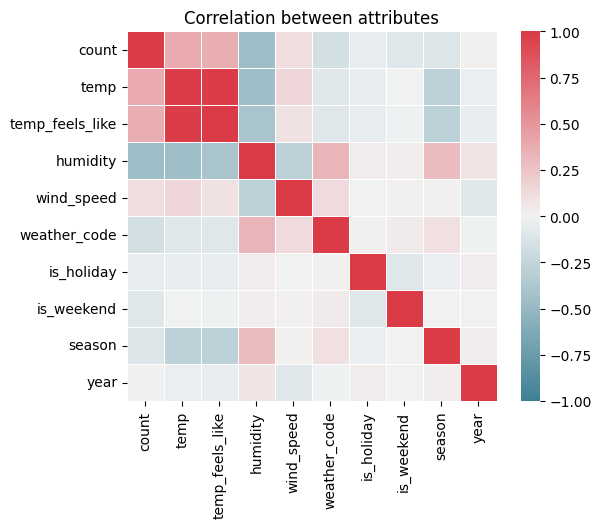

In [255]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    df_bike.corr(method="pearson", numeric_only=True),
    cmap=cmap,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=0.5,
)
plt.title("Correlation between attributes")

Wie aus der Korrelationsmatrix ersichtlich ist, sind die oben gemachten Beobachtungen korrekt. Die Anzahl der gemeinsam genutzten Fahrräder (count) korreliert positiv mit der Temperatur (temp) und negativ mit der Luftfeuchtigkeit (humidity).

### Abschnitt 4. Datenverarbeitung

In [256]:
# df_bike["n_day"] = pd.to_numeric(df_bike["timestamp"].dt.strftime("%d"))
# df_bike["n_month"] = df_bike["timestamp"].dt.month
df_bike["n_hour"] = df_bike["timestamp"].dt.hour
df_bike["n_day_of_week"] = df_bike["timestamp"].dt.dayofweek
df_bike["n_day_of_year"] = df_bike["timestamp"].dt.dayofyear
df_bike.tail()

timestamp  count  temp  temp_feels_like  humidity  wind_speed  \
17409 2017-01-03 19:00:00   1042   5.0              1.0      81.0        19.0   
17410 2017-01-03 20:00:00    541   5.0              1.0      81.0        21.0   
17411 2017-01-03 21:00:00    337   5.5              1.5      78.5        24.0   
17412 2017-01-03 22:00:00    224   5.5              1.5      76.0        23.0   
17413 2017-01-03 23:00:00    139   5.0              1.0      76.0        22.0   

       weather_code  is_holiday  is_weekend  season  year    month      time  \
17409           3.0         0.0         0.0     3.0  2017  January  19:00:00   
17410           4.0         0.0         0.0     3.0  2017  January  20:00:00   
17411           4.0         0.0         0.0     3.0  2017  January  21:00:00   
17412           4.0         0.0         0.0     3.0  2017  January  22:00:00   
17413           2.0         0.0         0.0     3.0  2017  January  23:00:00   

      day_of_week season_name         day  n_hour  n_day_of_week  \
17409     Tuesday      Winter  2017-01-03      19              1   
17410     Tuesday      Winter  2017-01-03      20              1   
17411     Tuesday      Winter  2017-01-03      21              1   
17412     Tuesday      Winter  2017-01-03      22              1   
17413     Tuesday      Winter  2017-01-03      23              1   

       n_day_of_year  
17409              3  
17410              3  
17411              3  
17412              3  
17413              3

#### 4.2. Removing outliers

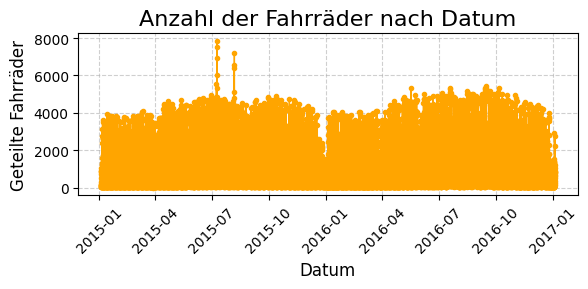

In [257]:
import matplotlib.pyplot as plt

# تعيين حجم الرسم والدقة
plt.figure(figsize=(6, 3), dpi=100)

# رسم البيانات
plt.plot(
    df_bike["timestamp"],
    df_bike["count"],
    color="orange",
    marker="o",
    linestyle="-",
    linewidth=1,
    markersize=3,
)

plt.title("Anzahl der Fahrräder nach Datum", fontsize=16)
plt.xlabel("Datum", fontsize=12)
plt.ylabel("Geteilte Fahrräder", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [258]:
outliers = df_bike[df_bike["count"] > 6000]
outliers

timestamp  count  temp  temp_feels_like  humidity  wind_speed  \
4461 2015-07-09 08:00:00   7531  14.5             14.5      61.0        19.0   
4469 2015-07-09 16:00:00   6033  23.0             22.0      26.0        11.0   
4470 2015-07-09 17:00:00   7860  23.0             22.0      27.0        11.0   
4471 2015-07-09 18:00:00   6913  22.5             21.5      29.0        13.0   
5129 2015-08-06 08:00:00   6585  19.0             19.0      78.0        12.0   
5138 2015-08-06 17:00:00   7208  22.5             22.5      55.0        17.5   
5139 2015-08-06 18:00:00   6394  21.5             21.5      58.5        20.0   

      weather_code  is_holiday  is_weekend  season  year   month      time  \
4461           2.0         0.0         0.0     1.0  2015    July  08:00:00   
4469           1.0         0.0         0.0     1.0  2015    July  16:00:00   
4470           1.0         0.0         0.0     1.0  2015    July  17:00:00   
4471           1.0         0.0         0.0     1.0  2015    July  18:00:00   
5129           7.0         0.0         0.0     1.0  2015  August  08:00:00   
5138           2.0         0.0         0.0     1.0  2015  August  17:00:00   
5139           2.0         0.0         0.0     1.0  2015  August  18:00:00   

     day_of_week season_name         day  n_hour  n_day_of_week  n_day_of_year  
4461    Thursday      Summer  2015-07-09       8              3            190  
4469    Thursday      Summer  2015-07-09      16              3            190  
4470    Thursday      Summer  2015-07-09      17              3            190  
4471    Thursday      Summer  2015-07-09      18              3            190  
5129    Thursday      Summer  2015-08-06       8              3            218  
5138    Thursday      Summer  2015-08-06      17              3            218  
5139    Thursday      Summer  2015-08-06      18              3            218

In [259]:
df_bike = df_bike.drop(outliers.index)

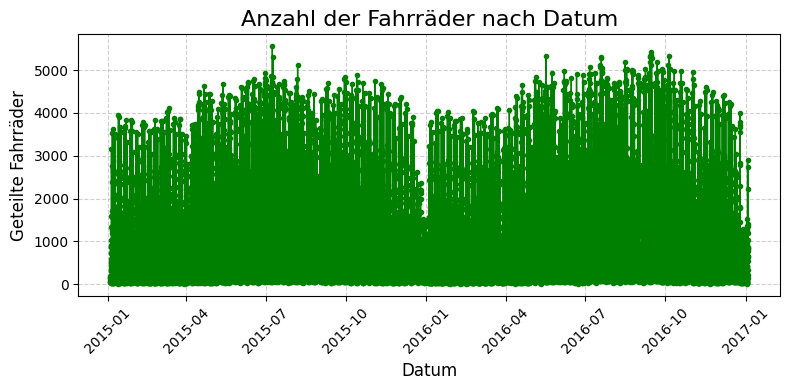

In [260]:
# تعيين حجم الرسم والدقة
plt.figure(figsize=(8, 4), dpi=100)

# رسم البيانات
plt.plot(
    df_bike["timestamp"],
    df_bike["count"],
    color="green",
    marker="o",
    linestyle="-",
    linewidth=1,
    markersize=3,
)

plt.title("Anzahl der Fahrräder nach Datum", fontsize=16)
plt.xlabel("Datum", fontsize=12)
plt.ylabel("Geteilte Fahrräder", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [261]:
# pd.set_option("display.max_rows", None)

start_date = "2015-12-24"
end_date = "2016-01-05"
filtered_data = df_bike[
    (df_bike["timestamp"] >= start_date) & (df_bike["timestamp"] <= end_date)
]

selected_data = filtered_data[["timestamp", "count"]]
selected_data

timestamp  count
8451 2015-12-24 00:00:00    175
8452 2015-12-24 01:00:00    159
8453 2015-12-24 02:00:00    104
8454 2015-12-24 03:00:00     74
8455 2015-12-24 04:00:00     66
...                  ...    ...
8735 2016-01-04 20:00:00    614
8736 2016-01-04 21:00:00    397
8737 2016-01-04 22:00:00    293
8738 2016-01-04 23:00:00    174
8739 2016-01-05 00:00:00     93

[289 rows x 2 columns]

#### 4.3. One-hot encoding


Da wir nicht wissen, welcher Code zu welcher Jahreszeit gehört, noch welcher Code zu welchem Wetter gehört, ist die Codierung beider Attribute in einer One-Hot-Codierung die beste Option. Die Modelle können sowohl mit One-Hot-Codierung als auch ohne One-Hot-Codierung trainiert werden, um zu bestimmen, welche Option bessere Ergebnisse liefert.

In [262]:
df_bike.reset_index(drop=True, inplace=True)

In [263]:
df_bike

timestamp  count  temp  temp_feels_like  humidity  wind_speed  \
0     2015-01-04 00:00:00    182   3.0              2.0      93.0         6.0   
1     2015-01-04 01:00:00    138   3.0              2.5      93.0         5.0   
2     2015-01-04 02:00:00    134   2.5              2.5      96.5         0.0   
3     2015-01-04 03:00:00     72   2.0              2.0     100.0         0.0   
4     2015-01-04 04:00:00     47   2.0              0.0      93.0         6.5   
...                   ...    ...   ...              ...       ...         ...   
17402 2017-01-03 19:00:00   1042   5.0              1.0      81.0        19.0   
17403 2017-01-03 20:00:00    541   5.0              1.0      81.0        21.0   
17404 2017-01-03 21:00:00    337   5.5              1.5      78.5        24.0   
17405 2017-01-03 22:00:00    224   5.5              1.5      76.0        23.0   
17406 2017-01-03 23:00:00    139   5.0              1.0      76.0        22.0   

       weather_code  is_holiday  is_weekend  season  year    month      time  \
0               3.0         0.0         1.0     3.0  2015  January  00:00:00   
1               1.0         0.0         1.0     3.0  2015  January  01:00:00   
2               1.0         0.0         1.0     3.0  2015  January  02:00:00   
3               1.0         0.0         1.0     3.0  2015  January  03:00:00   
4               1.0         0.0         1.0     3.0  2015  January  04:00:00   
...             ...         ...         ...     ...   ...      ...       ...   
17402           3.0         0.0         0.0     3.0  2017  January  19:00:00   
17403           4.0         0.0         0.0     3.0  2017  January  20:00:00   
17404           4.0         0.0         0.0     3.0  2017  January  21:00:00   
17405           4.0         0.0         0.0     3.0  2017  January  22:00:00   
17406           2.0         0.0         0.0     3.0  2017  January  23:00:00   

      day_of_week season_name         day  n_hour  n_day_of_week  \
0          Sunday      Winter  2015-01-04       0              6   
1          Sunday      Winter  2015-01-04       1              6   
2          Sunday      Winter  2015-01-04       2              6   
3          Sunday      Winter  2015-01-04       3              6   
4          Sunday      Winter  2015-01-04       4              6   
...           ...         ...         ...     ...            ...   
17402     Tuesday      Winter  2017-01-03      19              1   
17403     Tuesday      Winter  2017-01-03      20              1   
17404     Tuesday      Winter  2017-01-03      21              1   
17405     Tuesday      Winter  2017-01-03      22              1   
17406     Tuesday      Winter  2017-01-03      23              1   

       n_day_of_year  
0                  4  
1                  4  
2                  4  
3                  4  
4                  4  
...              ...  
17402              3  
17403              3  
17404              3  
17405              3  
17406              3  

[17407 rows x 19 columns]

In [264]:
columns_to_encode = ["weather_code", "season"]

In [265]:
encoder_weather = OneHotEncoder(sparse=False)
encoder_weather.fit(df_bike[["weather_code"]])
encoded_weather = encoder_weather.transform(df_bike[["weather_code"]])
encoded_weather_df = pd.DataFrame(
    encoded_weather, columns=encoder_weather.get_feature_names_out(["weather_code"])
)
encoded_weather_df

C:\Users\Hend\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


weather_code_1.0  weather_code_2.0  weather_code_3.0  weather_code_4.0  \
0                   0.0               0.0               1.0               0.0   
1                   1.0               0.0               0.0               0.0   
2                   1.0               0.0               0.0               0.0   
3                   1.0               0.0               0.0               0.0   
4                   1.0               0.0               0.0               0.0   
...                 ...               ...               ...               ...   
17402               0.0               0.0               1.0               0.0   
17403               0.0               0.0               0.0               1.0   
17404               0.0               0.0               0.0               1.0   
17405               0.0               0.0               0.0               1.0   
17406               0.0               1.0               0.0               0.0   

       weather_code_7.0  weather_code_10.0  weather_code_26.0  
0                   0.0                0.0                0.0  
1                   0.0                0.0                0.0  
2                   0.0                0.0                0.0  
3                   0.0                0.0                0.0  
4                   0.0                0.0                0.0  
...                 ...                ...                ...  
17402               0.0                0.0                0.0  
17403               0.0                0.0                0.0  
17404               0.0                0.0                0.0  
17405               0.0                0.0                0.0  
17406               0.0                0.0                0.0  

[17407 rows x 7 columns]

In [266]:
encoder_season = OneHotEncoder(sparse=False)
encoder_season.fit(df_bike[["season"]])
encoded_season = encoder_season.transform(df_bike[["season"]])
encoded_season_df = pd.DataFrame(
    encoded_season, columns=encoder_season.get_feature_names_out(["season"])
)

encoded_season_df

C:\Users\Hend\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


season_0.0  season_1.0  season_2.0  season_3.0
0             0.0         0.0         0.0         1.0
1             0.0         0.0         0.0         1.0
2             0.0         0.0         0.0         1.0
3             0.0         0.0         0.0         1.0
4             0.0         0.0         0.0         1.0
...           ...         ...         ...         ...
17402         0.0         0.0         0.0         1.0
17403         0.0         0.0         0.0         1.0
17404         0.0         0.0         0.0         1.0
17405         0.0         0.0         0.0         1.0
17406         0.0         0.0         0.0         1.0

[17407 rows x 4 columns]

In [267]:
# encoded_season_df
df_bike = pd.concat(
    [
        df_bike,
        encoded_weather_df,
    ],
    axis=1,
)
df_bike

timestamp  count  temp  temp_feels_like  humidity  wind_speed  \
0     2015-01-04 00:00:00    182   3.0              2.0      93.0         6.0   
1     2015-01-04 01:00:00    138   3.0              2.5      93.0         5.0   
2     2015-01-04 02:00:00    134   2.5              2.5      96.5         0.0   
3     2015-01-04 03:00:00     72   2.0              2.0     100.0         0.0   
4     2015-01-04 04:00:00     47   2.0              0.0      93.0         6.5   
...                   ...    ...   ...              ...       ...         ...   
17402 2017-01-03 19:00:00   1042   5.0              1.0      81.0        19.0   
17403 2017-01-03 20:00:00    541   5.0              1.0      81.0        21.0   
17404 2017-01-03 21:00:00    337   5.5              1.5      78.5        24.0   
17405 2017-01-03 22:00:00    224   5.5              1.5      76.0        23.0   
17406 2017-01-03 23:00:00    139   5.0              1.0      76.0        22.0   

       weather_code  is_holiday  is_weekend  season  ...  n_hour  \
0               3.0         0.0         1.0     3.0  ...       0   
1               1.0         0.0         1.0     3.0  ...       1   
2               1.0         0.0         1.0     3.0  ...       2   
3               1.0         0.0         1.0     3.0  ...       3   
4               1.0         0.0         1.0     3.0  ...       4   
...             ...         ...         ...     ...  ...     ...   
17402           3.0         0.0         0.0     3.0  ...      19   
17403           4.0         0.0         0.0     3.0  ...      20   
17404           4.0         0.0         0.0     3.0  ...      21   
17405           4.0         0.0         0.0     3.0  ...      22   
17406           2.0         0.0         0.0     3.0  ...      23   

      n_day_of_week n_day_of_year weather_code_1.0 weather_code_2.0  \
0                 6             4              0.0              0.0   
1                 6             4              1.0              0.0   
2                 6             4              1.0              0.0   
3                 6             4              1.0              0.0   
4                 6             4              1.0              0.0   
...             ...           ...              ...              ...   
17402             1             3              0.0              0.0   
17403             1             3              0.0              0.0   
17404             1             3              0.0              0.0   
17405             1             3              0.0              0.0   
17406             1             3              0.0              1.0   

      weather_code_3.0  weather_code_4.0  weather_code_7.0  weather_code_10.0  \
0                  1.0               0.0               0.0                0.0   
1                  0.0               0.0               0.0                0.0   
2                  0.0               0.0               0.0                0.0   
3                  0.0               0.0               0.0                0.0   
4                  0.0               0.0               0.0                0.0   
...                ...               ...               ...                ...   
17402              1.0               0.0               0.0                0.0   
17403              0.0               1.0               0.0                0.0   
17404              0.0               1.0               0.0                0.0   
17405              0.0               1.0               0.0                0.0   
17406              0.0               0.0               0.0                0.0   

       weather_code_26.0  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
17402                0.0  
17403                0.0  
17404                0.0  
17405                0.0  
17406                0.0  

[17407 rows x 26 columns]

### 4.4 Entfernen redundanter Daten

In [273]:
df_bike_modified = df_bike.drop(
    [
        "timestamp",
        "temp_feels_like",
        "weather_code",
        "season",
        "day_of_week",
        "month",
        "season_name",
        "day",
        "time",
        "is_weekend",
    ],
    axis=1,
)
df_bike_modified.head()

count  temp  humidity  wind_speed  is_holiday  year  n_hour  n_day_of_week  \
0    182   3.0      93.0         6.0         0.0  2015       0              6   
1    138   3.0      93.0         5.0         0.0  2015       1              6   
2    134   2.5      96.5         0.0         0.0  2015       2              6   
3     72   2.0     100.0         0.0         0.0  2015       3              6   
4     47   2.0      93.0         6.5         0.0  2015       4              6   

   n_day_of_year  weather_code_1.0  weather_code_2.0  weather_code_3.0  \
0              4               0.0               0.0               1.0   
1              4               1.0               0.0               0.0   
2              4               1.0               0.0               0.0   
3              4               1.0               0.0               0.0   
4              4               1.0               0.0               0.0   

   weather_code_4.0  weather_code_7.0  weather_code_10.0  weather_code_26.0  
0               0.0               0.0                0.0                0.0  
1               0.0               0.0                0.0                0.0  
2               0.0               0.0                0.0                0.0  
3               0.0               0.0                0.0                0.0  
4               0.0               0.0                0.0                0.0

### Section 5. Vorhersagemodelle

- Data splitting

In [269]:
X = df_bike_modified.drop(["count"], axis=1)
y = df_bike_modified["count"]

- Attributes in data (x) are scaled

In [270]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [271]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 5.1 Statistical Models

5.1.1 Linear Regression Model 


<div dir="rtl">

نموذج الانحدار Lasso هو طريقة تحليل الانحدار التي تقوم بتنفيذ كل من اختيار المتغير والتنظيم لتعزيز دقة التنبؤ وقابلية تفسير النموذج الإحصائي الناتج². 

في الانحدار الخطي المتعدد العادي، نستخدم مجموعة من المتغيرات التنبؤية والمتغير الاستجابة لتكوين نموذج¹. ولكن، عندما يكون المتغيرات التنبؤية مرتبطة بشدة، يمكن أن يصبح التعددية المتعاقبة مشكلة. يمكن أن يؤدي هذا إلى جعل تقديرات المعامل للنموذج غير موثوق بها ولها تباين عالٍ¹.

إحدى الطرق للتغلب على هذه المشكلة هي استخدام طريقة تعرف باسم انحدار Lasso، التي تسعى إلى تصغير مجموع مربعات الباقي (RSS) + λΣ|βj| حيث يتراوح j من 1 إلى p و λ ≥ 0¹. هذا المصطلح الثاني في المعادلة يُعرف بمصطلح التقليل¹.

الفكرة الأساسية لانحدار Lasso هي إدخال قليل من التحيز بحيث يمكن تقليل التباين بشكل كبير، مما يؤدي إلى خفض MSE الإجمالي¹. 

Lasso يحقق كلا من هذه الأهداف عبر فرض مجموع قيمة المطلق لمعاملات الانحدار أن تكون أقل من قيمة ثابتة، مما يجبر بعض المعاملات على أن تصبح صفرًا، مستبعدةً إياها من التأثير على التنبؤ².

